In [1]:
library(ggplot2)
library(coda)
library(knitr)
library(rjags)

ERROR: Error in library(rjags): non c'è alcun pacchetto chiamato 'rjags'


### Exercise 1

Given the following un-normalized posterior distribution:

$$
g(\theta \mid x) \propto \frac{1}{2} \exp \left( -\frac{(\theta + 3)^2}{2} \right) + \frac{1}{2} \exp \left( -\frac{(\theta - 3)^2}{2} \right)
$$

a) Draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm
b) Use a Norm(0,1) as random-walk candidate density
c) Plot the sampled distribution

The un-normalized posterior distribution is a mixture of two normal distributions: one centered in -3 and one in +3,
each with equal weight(1/2 and 1/2) and variance of 1:

$$
f(\theta \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(\theta - \mu)^2}{2\sigma^2} \right)
$$

To sample from a pdf we need to:
- Start with a value $\theta$
- Propose a new $\theta '$ from a proposal distribution $Q(s \mid \theta)$
- Decide whether to accept or not the new candidate sample on the basis of the Metropolis ratio: $\rho = \frac{f(s)}{f(\theta_t)} \frac{Q(\theta_t \mid s)}{Q(s \mid \theta_t)}$

If $\rho \geq 1$, the new candidate is accepted and $\theta_{t+1} = s$.

If $\rho < 1$, we only accept it with probability $\rho$:

Draw $u \sim U(0, 1)$ and set $\theta_{t+1} = s$ only if $u \leq \rho$.

If s is not accepted, we set $\theta_{t+1} = \theta_t$, i.e., the existing sample in the chain is repeated.

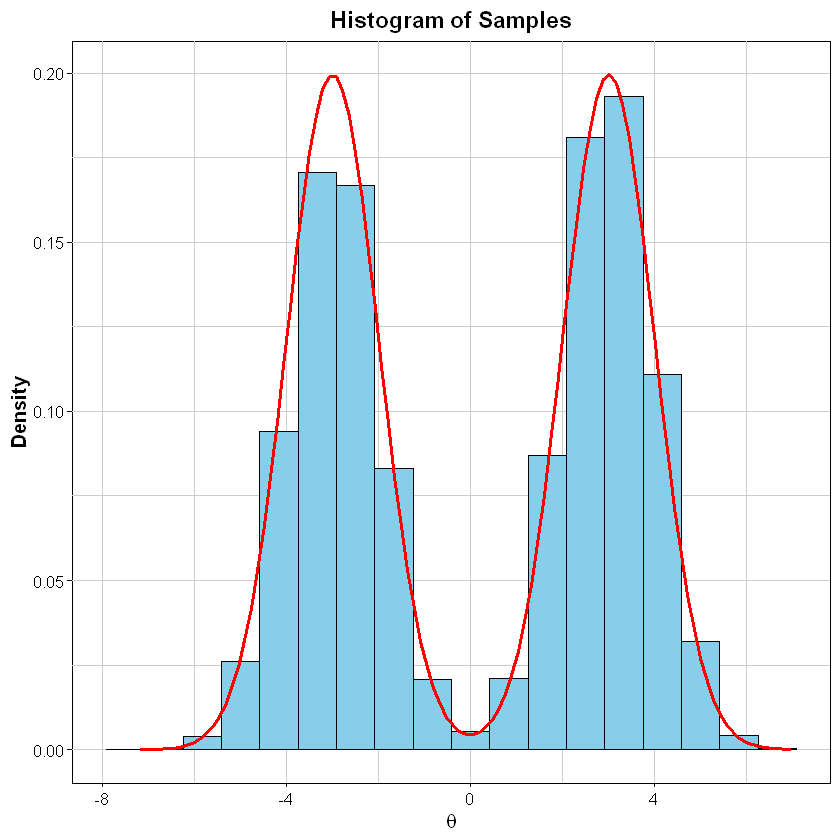

In [4]:
g = function(theta) {
    exp(-((theta + 3)^2)/2)/2 + exp(-((theta -3)^2)/2)/2 #unnormalized posterior distribution
}

Q = function(theta) {
    rnorm(1,theta,1) #proposal distribution (Norm(0,1))
}

n = 100000
start = 0

metropolis_hastings = function(start, n) {
    theta = numeric(n) #empty vector to store thetas values
    theta[1] = start #first value of the vector is the start and it is equal to zero
    for (i in 2:n) { #so we do a loop starting with the second value
        s = Q(theta[i-1]) #starting from the start and then proceeding 
        rho = (g(s) * dnorm(theta[i-1], s, 1)) / (g(theta[i-1]) * dnorm(s, theta[i-1], 1)) #calculate the acceptance ratio
        if (rho >= runif(1)) { #conditions on rho
            theta[i] = s
        } else {
            theta[i] = theta[i-1]
        }
    }
    return(theta)
}

samples = metropolis_hastings(start, n)
samples_df = data.frame(samples=samples)

bins_sturges = ceiling(log2(n) + 1)

ggplot(samples_df, aes(x=samples)) +
    geom_histogram(aes(y=after_stat(density)), bins=bins_sturges, fill="skyblue", color="black") + 
    stat_function(fun=function(x) 0.5*dnorm(x, mean =-3, sd=1) + 0.5*dnorm(x, mean=3, sd=1), color="red", linewidth= 1) + 
    labs(x=expression(theta), 
         y="Density", 
         title="Histogram of Samples") + 
    theme(
        text = element_text(size=12),
        axis.title.x = element_text(face="bold", size=12),
        axis.title.y = element_text(face="bold", size=12),
        axis.text = element_text(color="black"),
        axis.ticks = element_line(color="black"),
        plot.title = element_text(hjust=0.5, face="bold", size=14),
        panel.background = element_rect(fill = "white", color = "black"),
        panel.grid.major = element_line(linewidth=0.25, linetype='solid', color="grey80"),
        panel.grid.minor = element_line(linewidth=0.25, linetype='solid', color="grey80"))

b) Analyze the chain with the CODA package and plot the chain autocorrelation


Iterations = 1:1e+05
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      0.180402       3.152145       0.009968       0.163922 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
-4.591 -2.893  1.387  3.079  4.672 


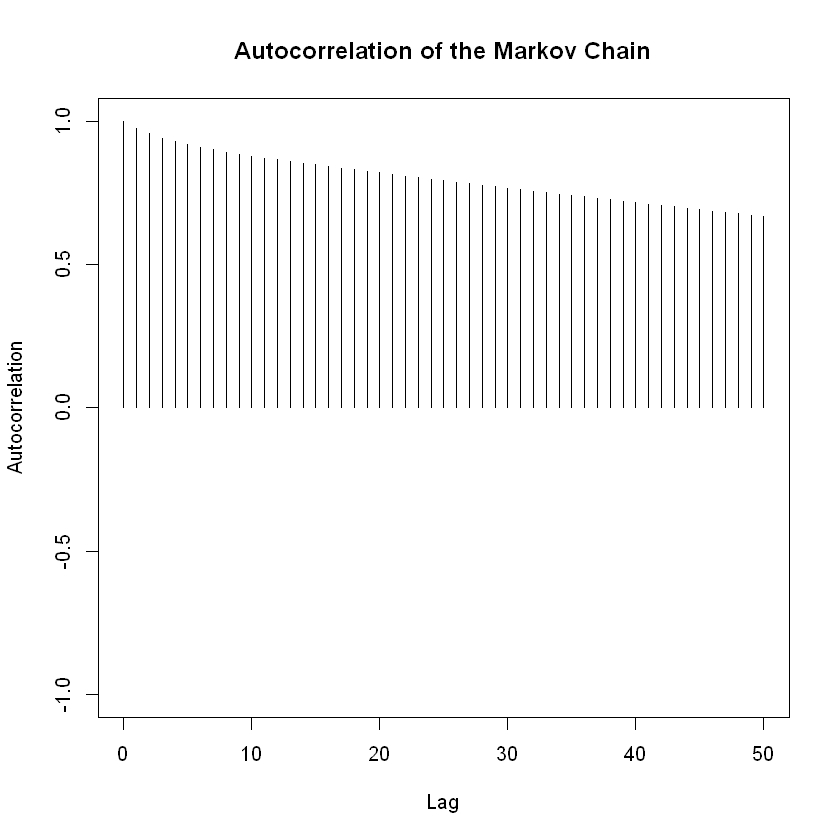

In [5]:
#autocorrelation gives me the correlation of the chain values with their past values. A high autocorrelation means high dependency on past
#values. 
mcmc_data = mcmc(samples) #converts samples in mcmc object required by coda
summary(mcmc_data)
autocorr.plot(mcmc_data, main="Autocorrelation of the Markov Chain")

c) Try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and try the chain autocorrelation function. What are the best parameters?

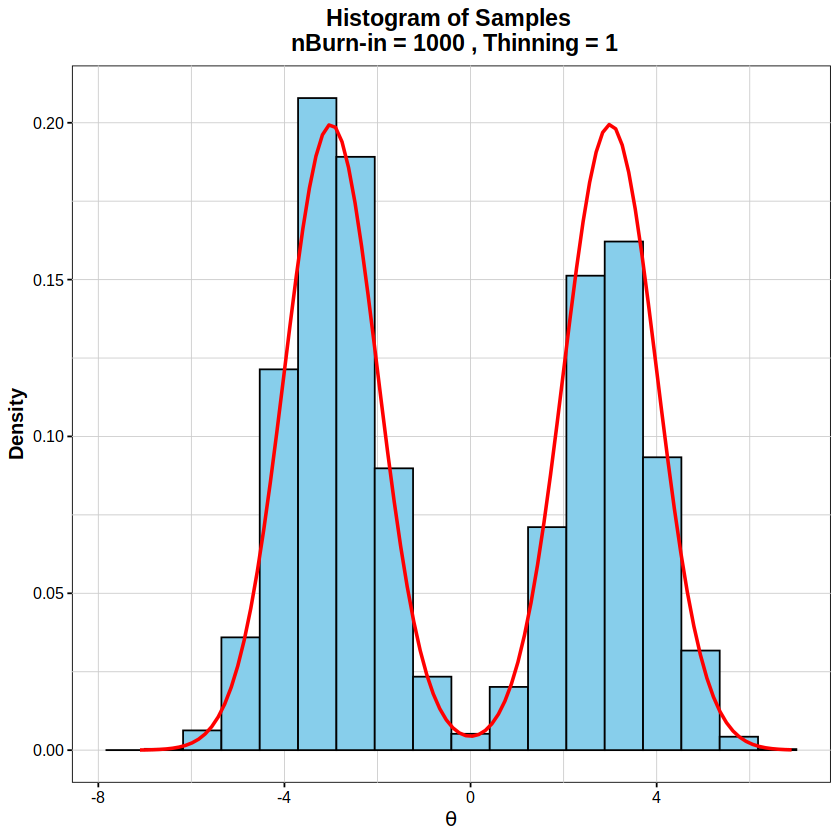

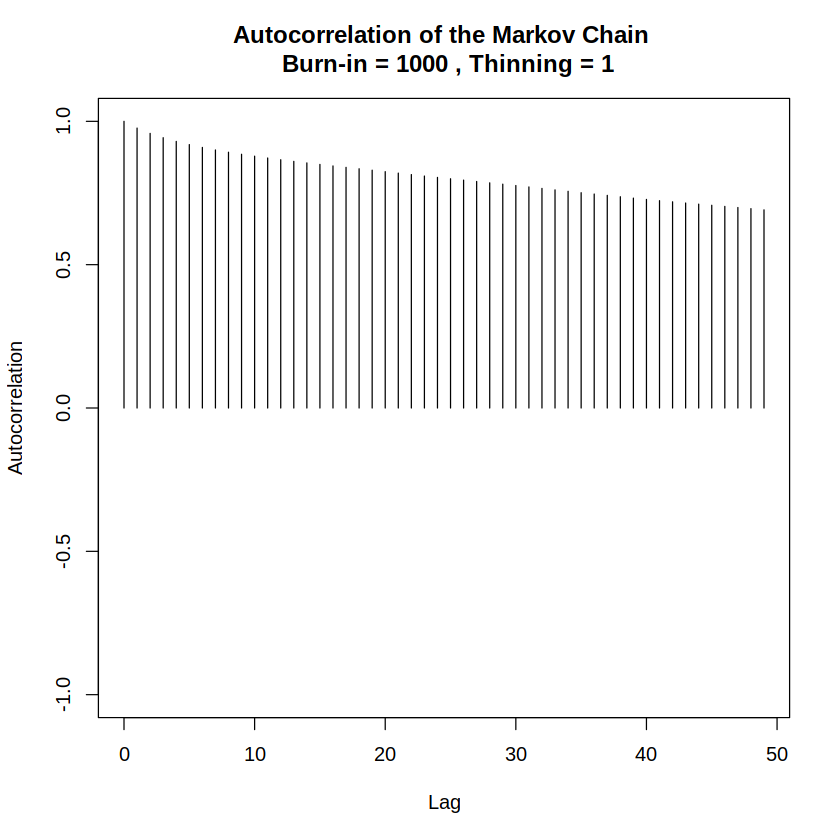

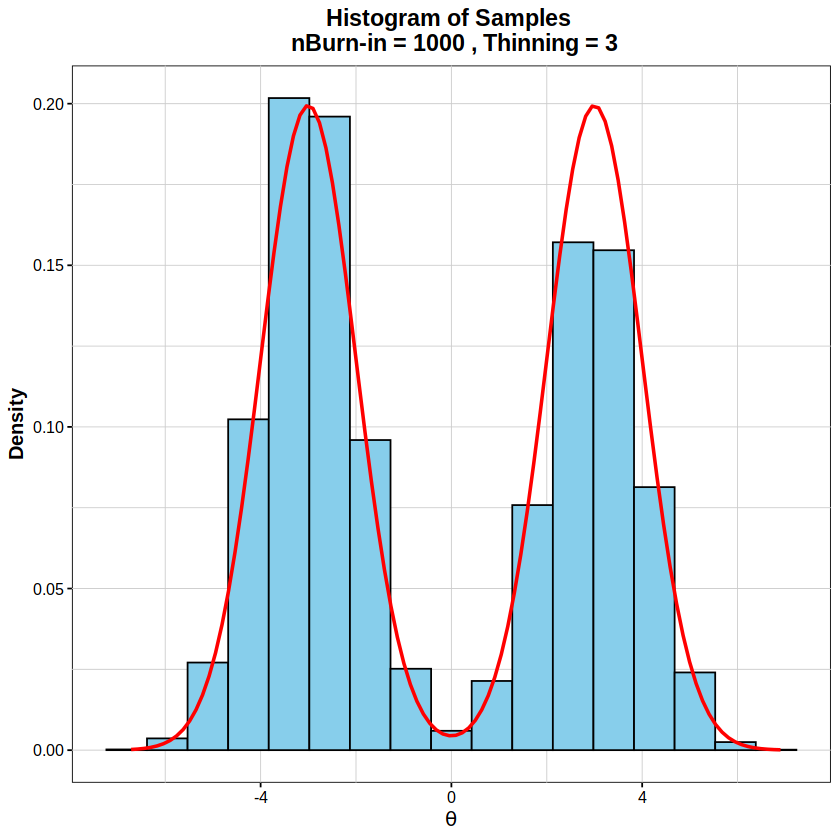

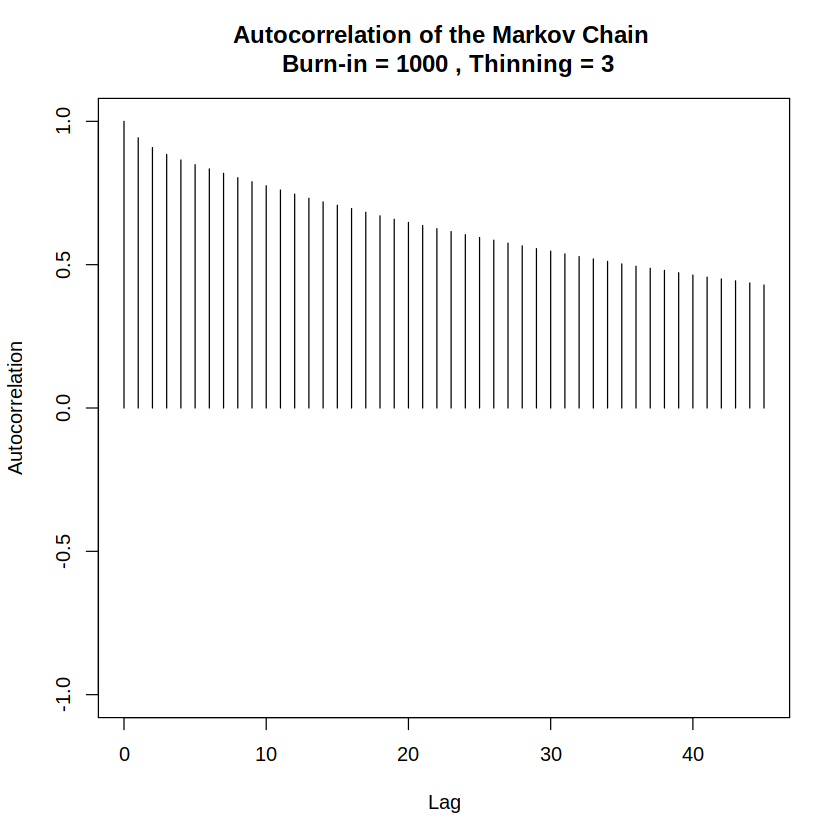

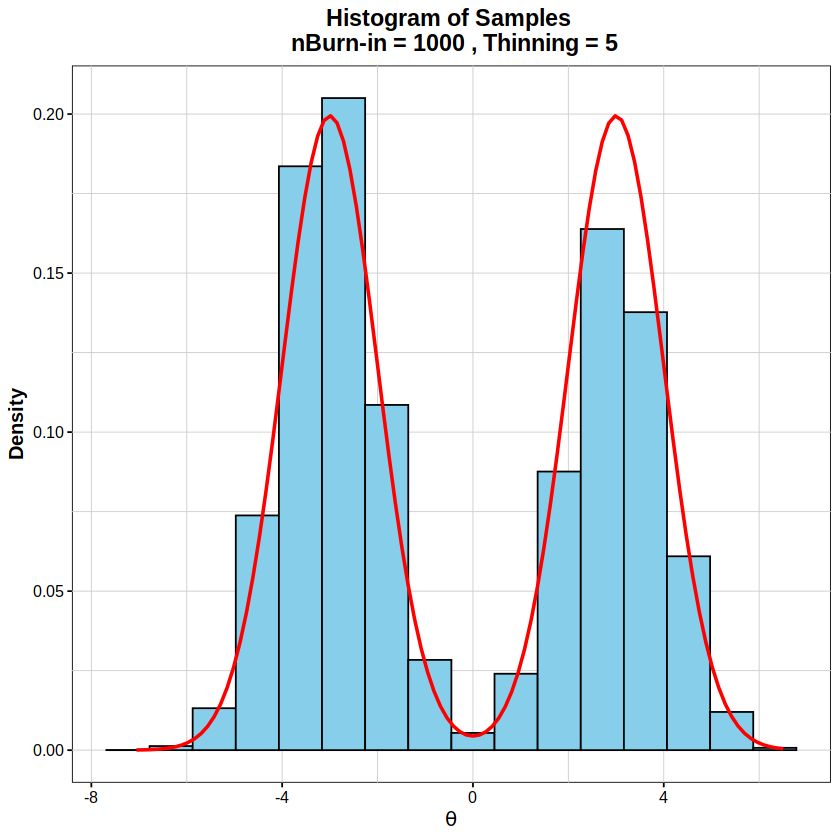

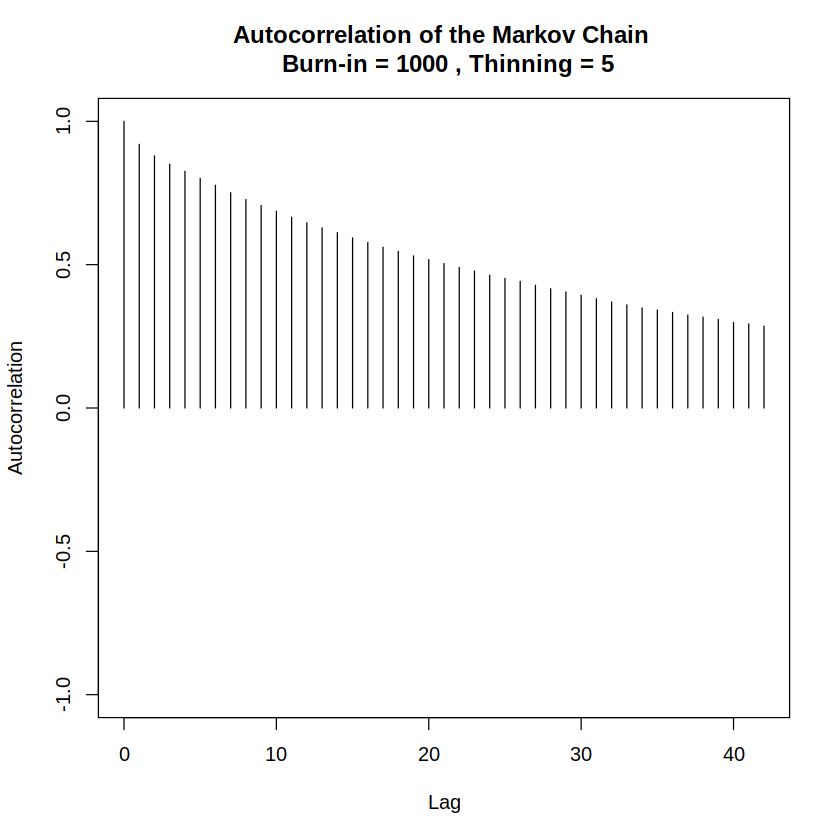

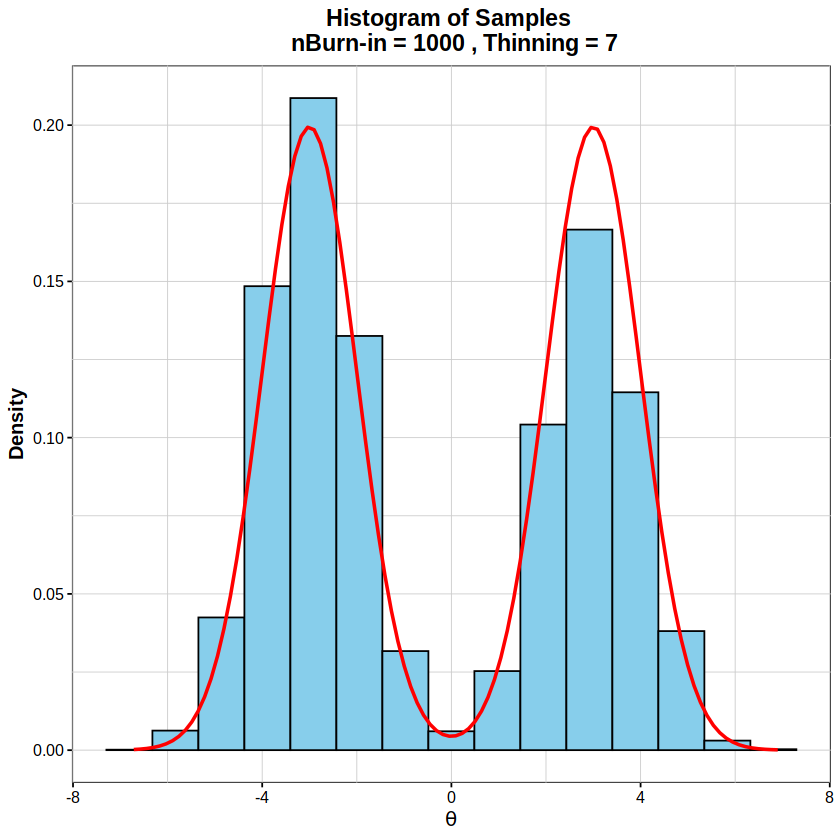

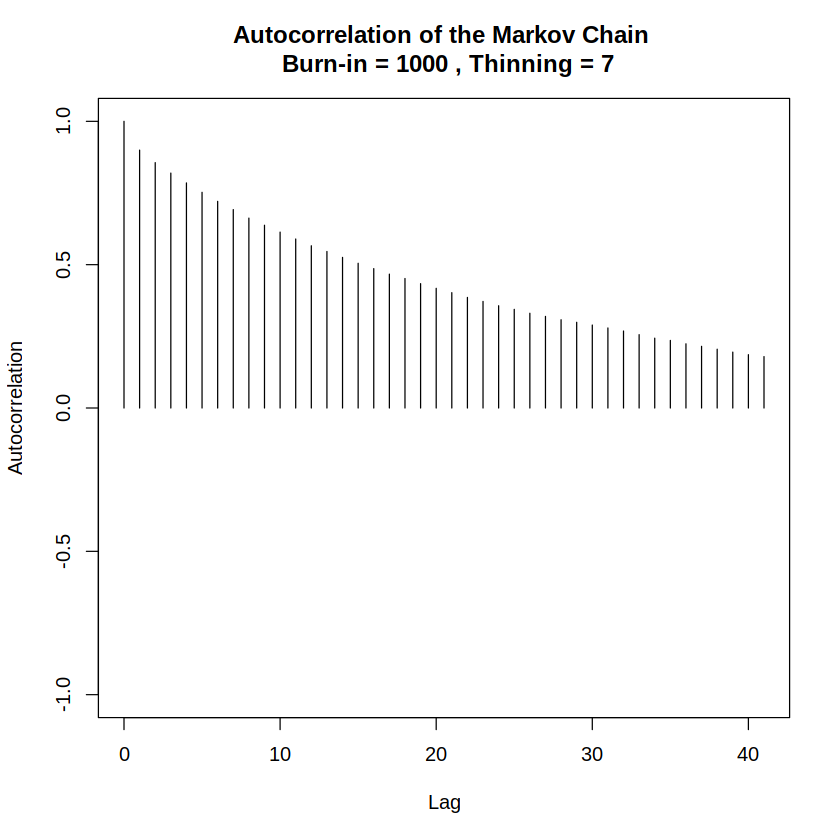

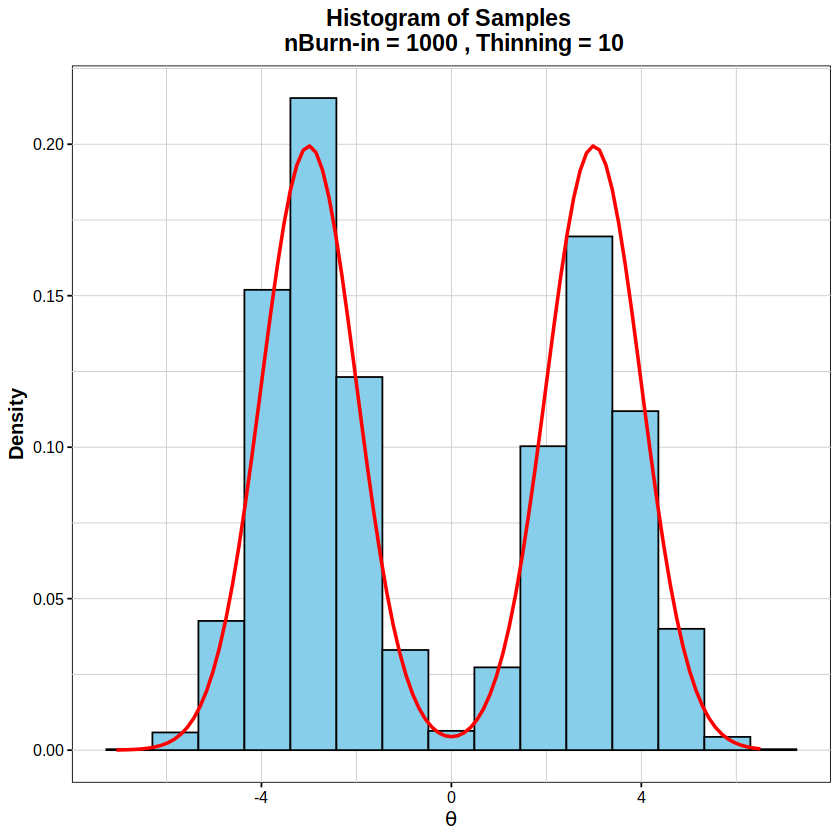

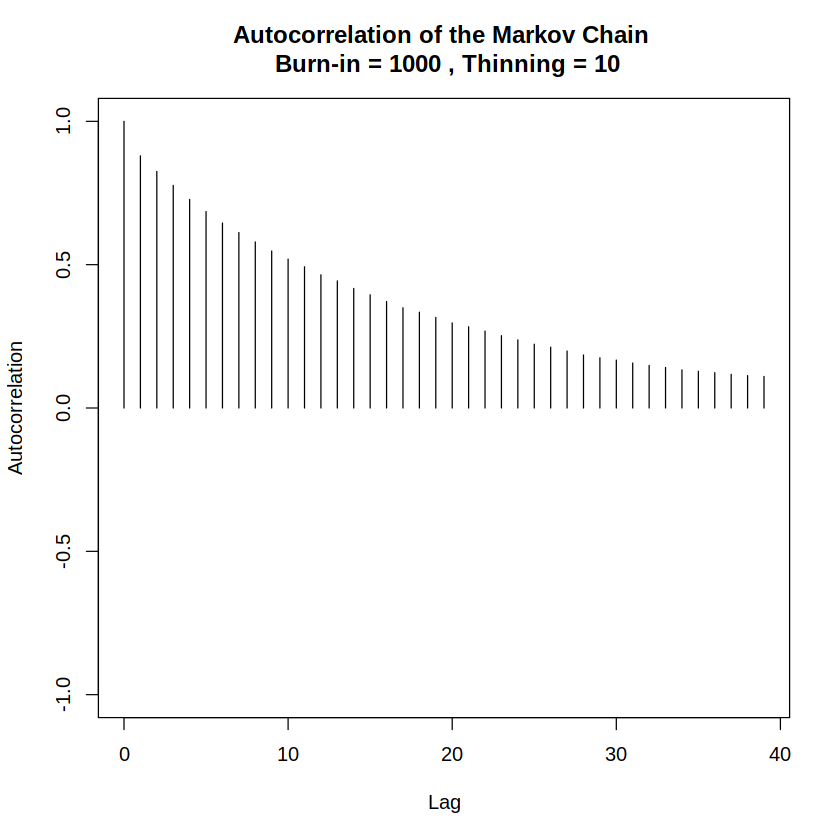

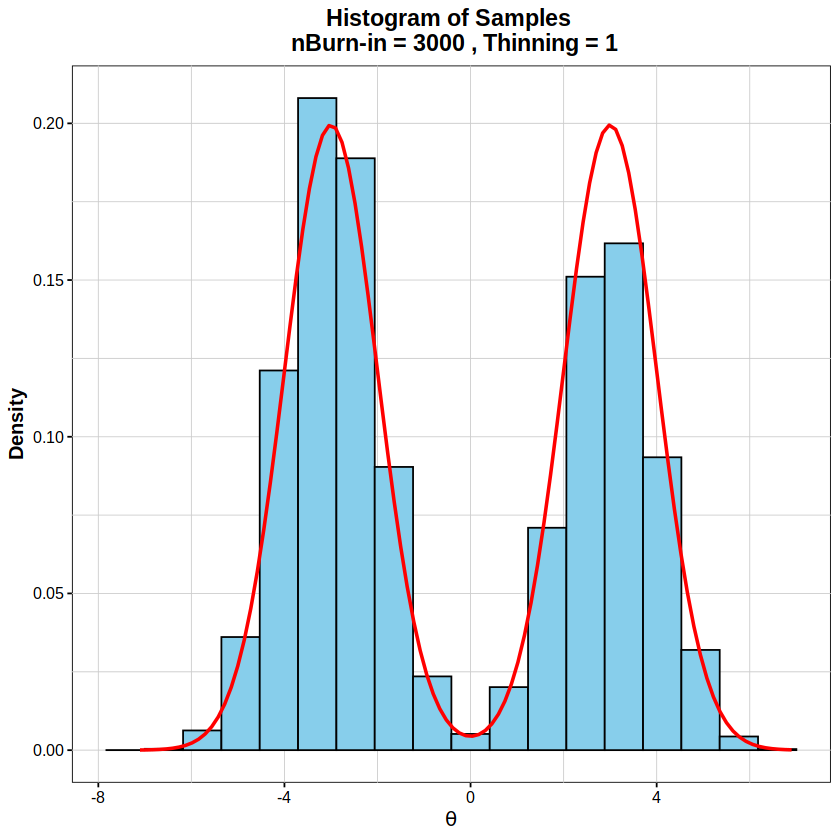

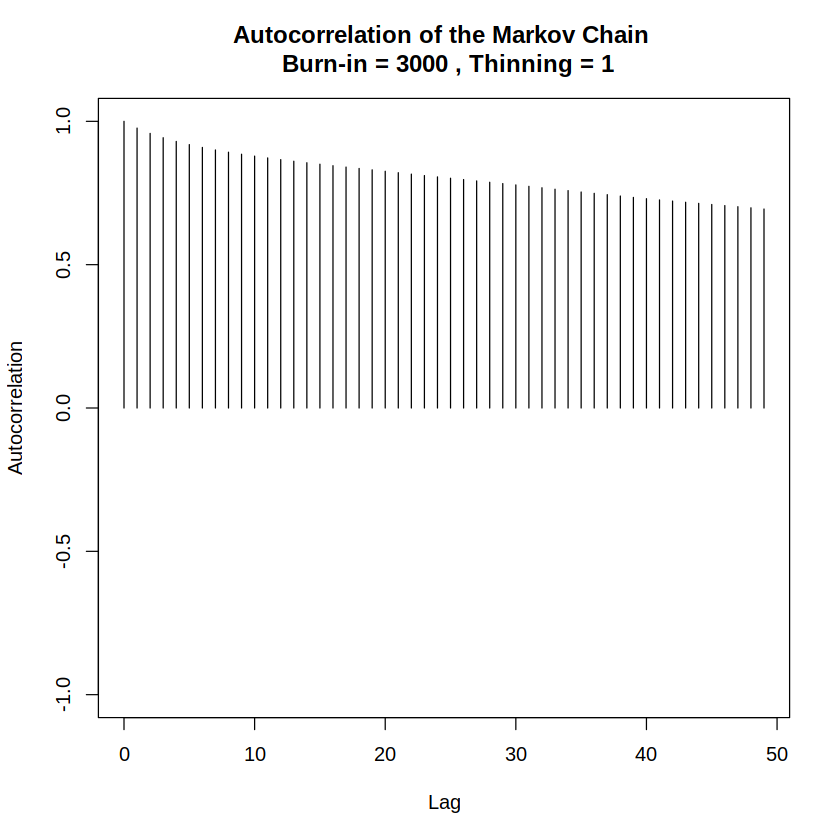

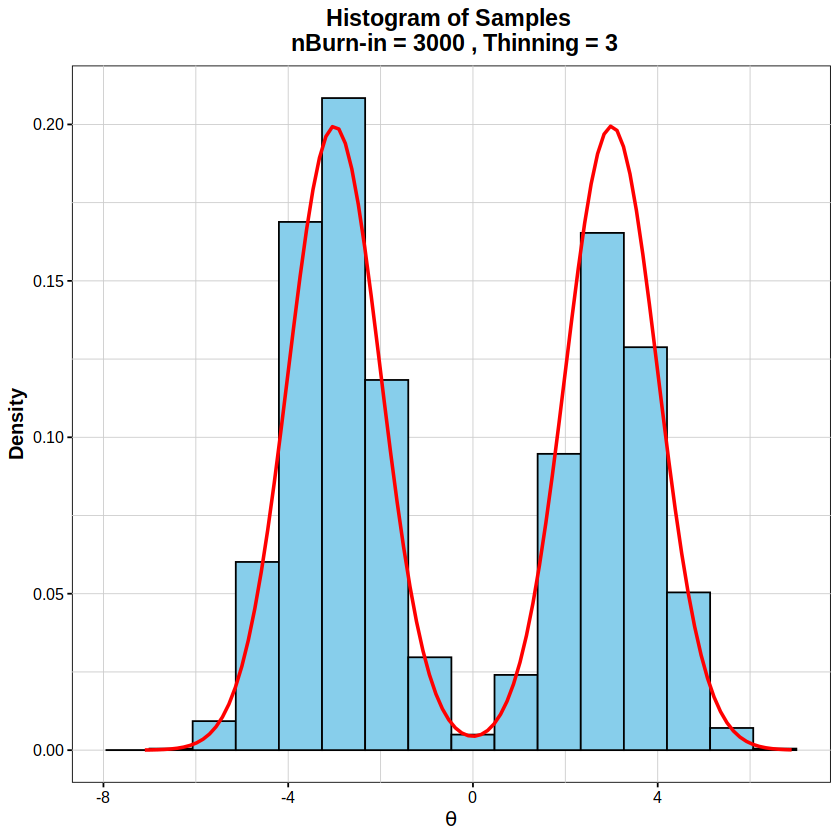

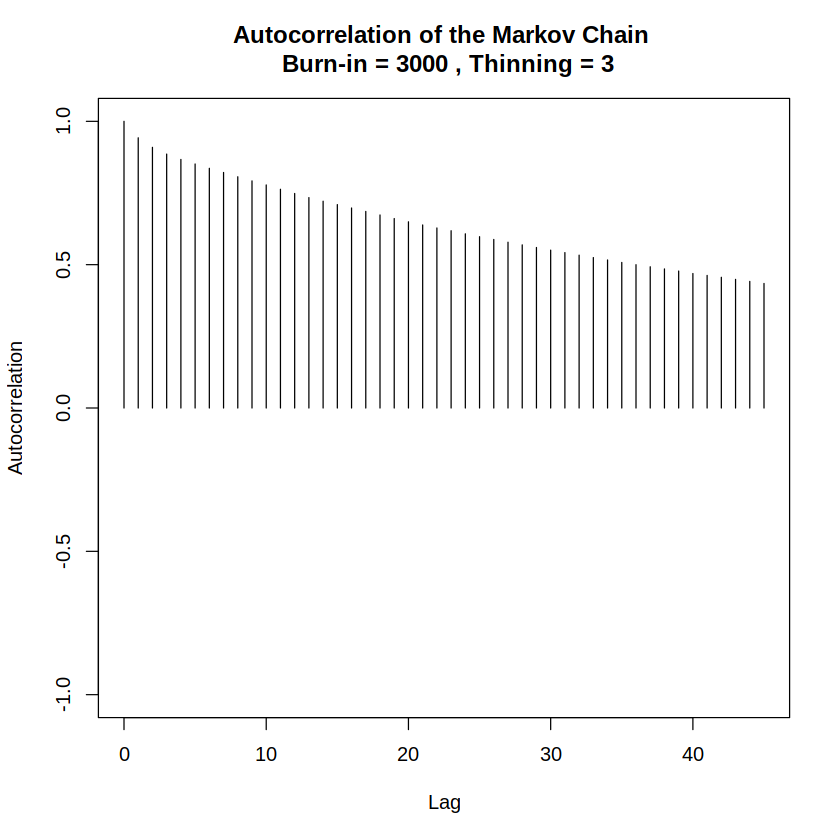

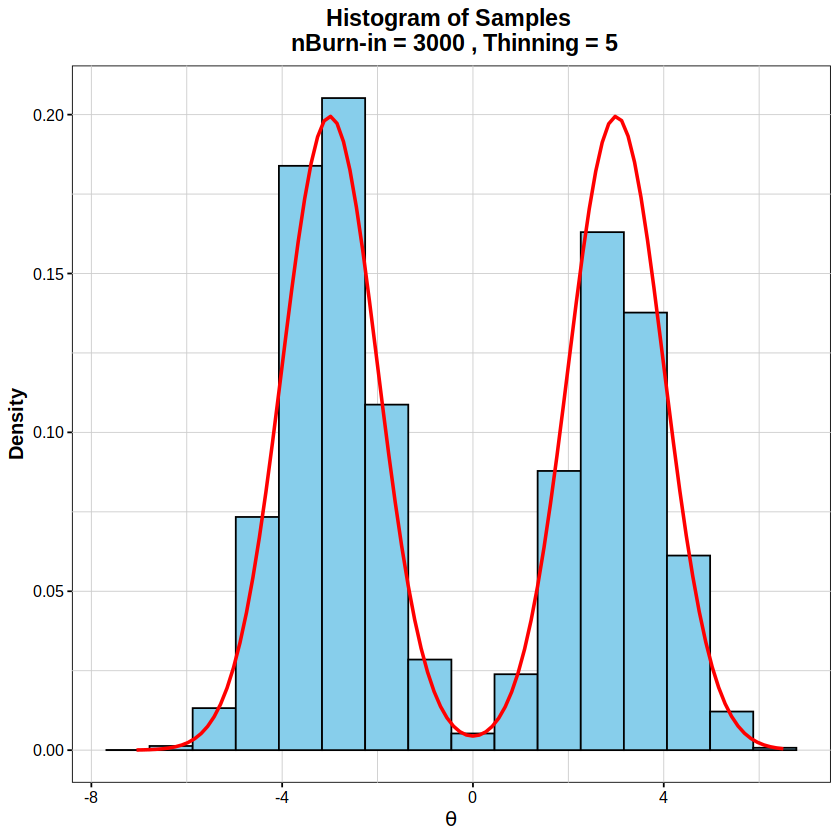

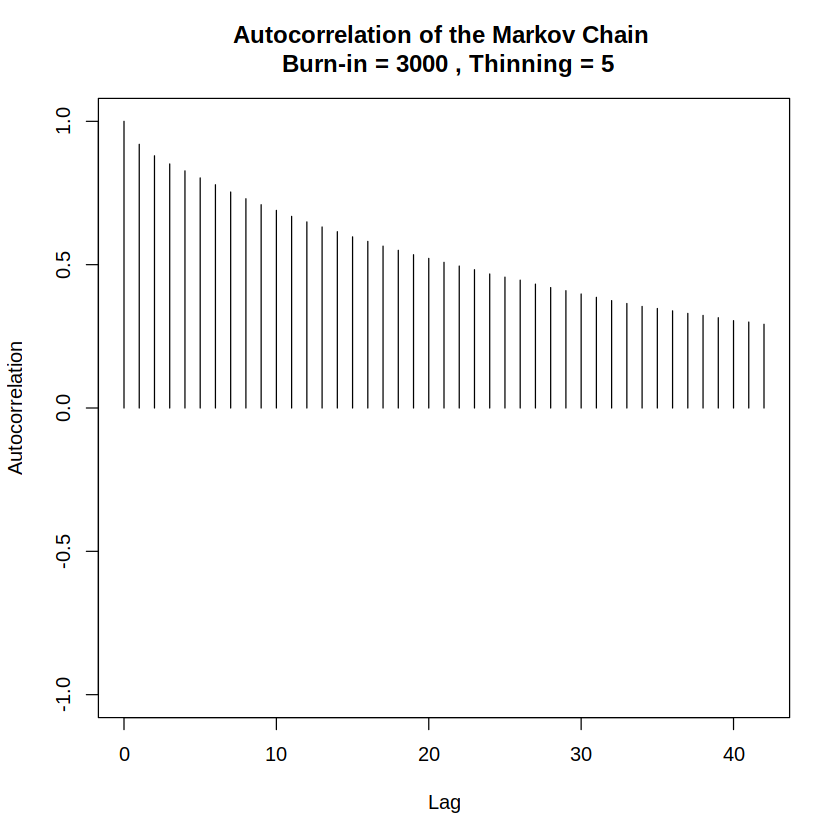

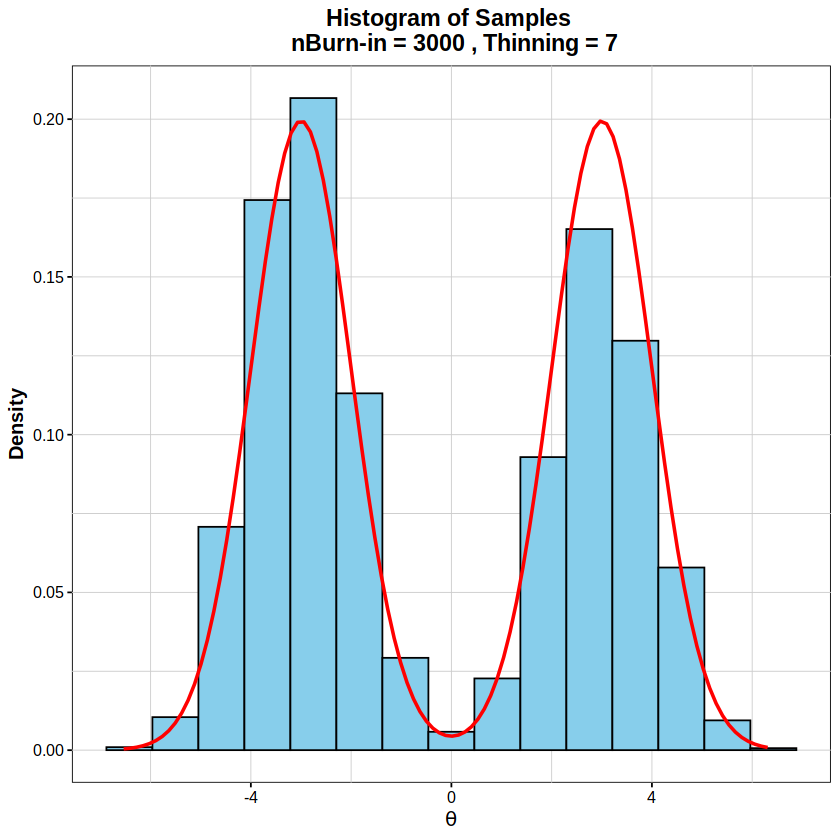

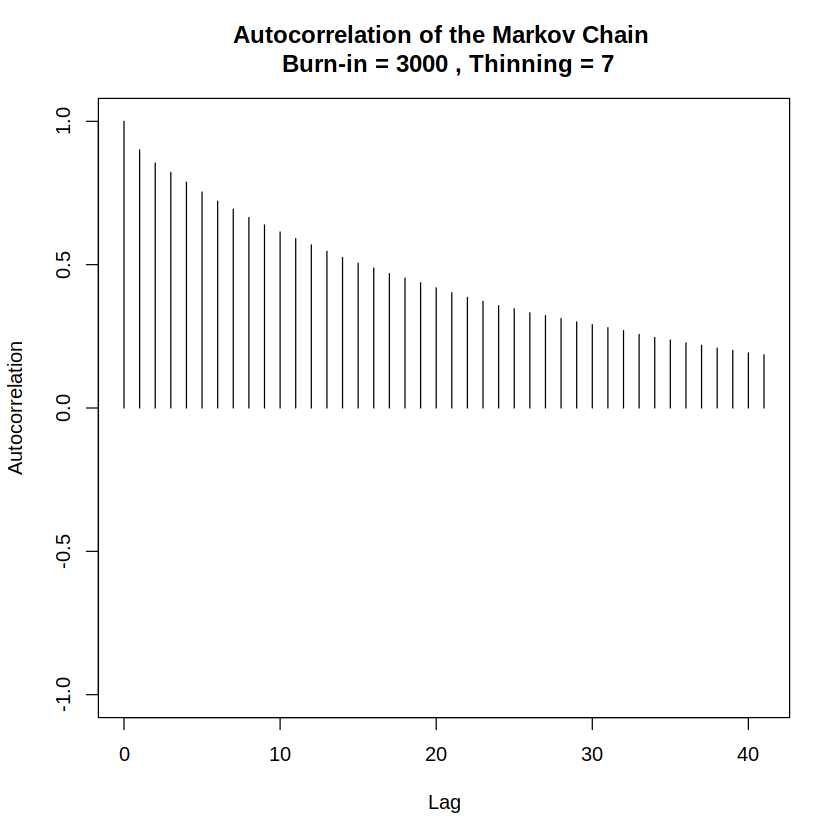

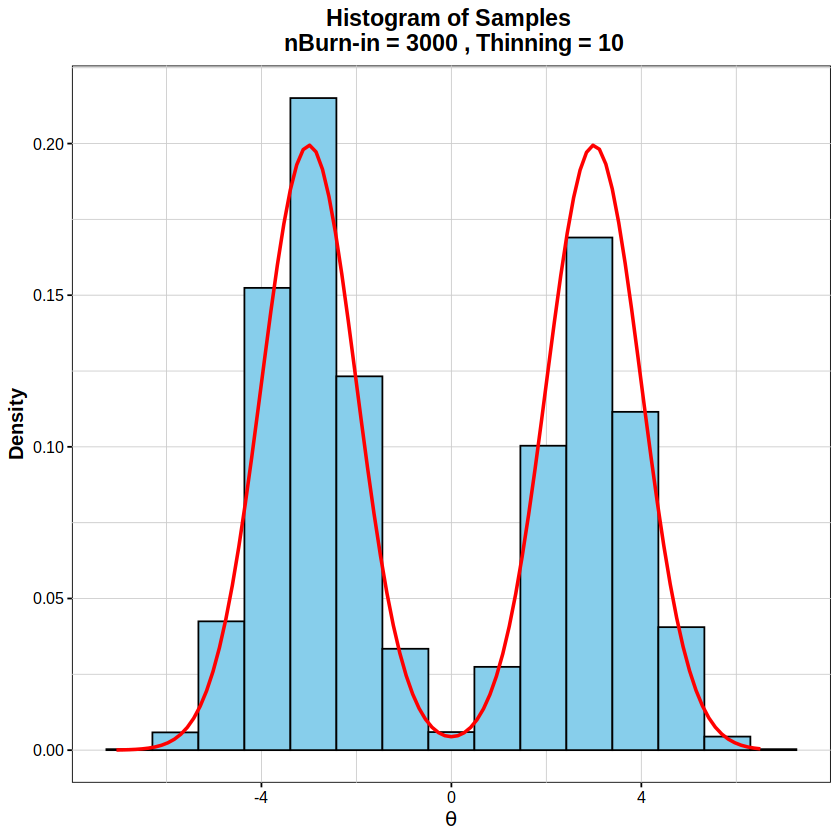

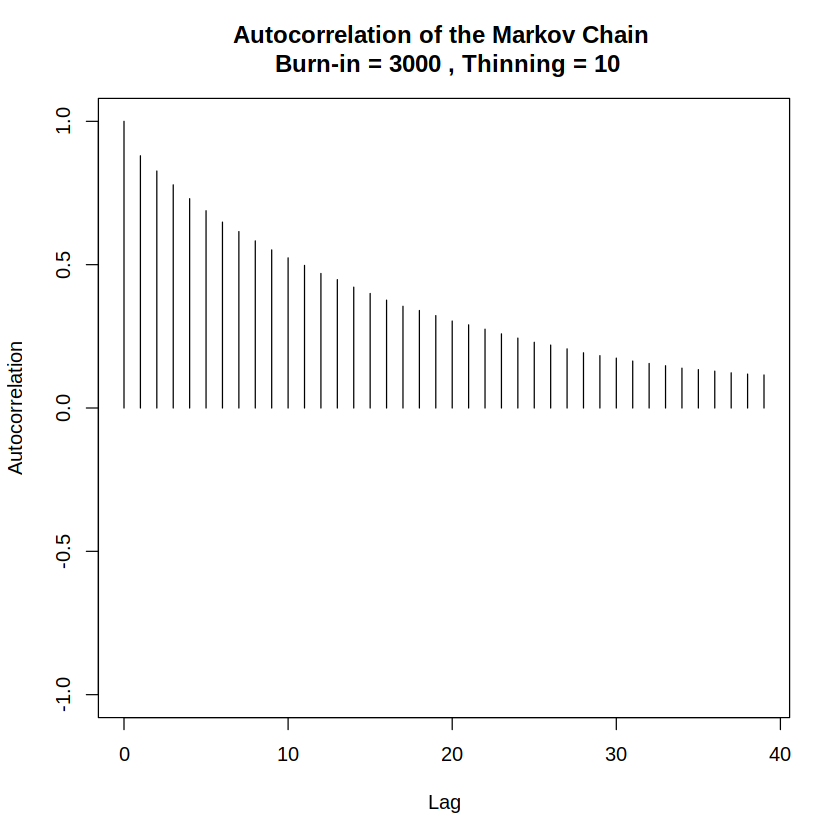

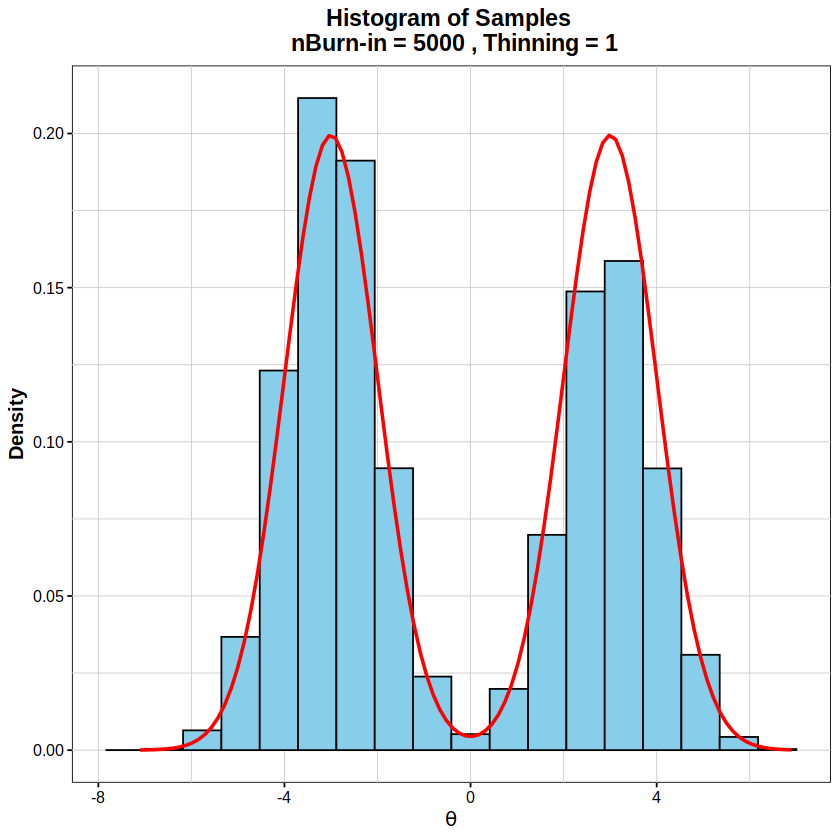

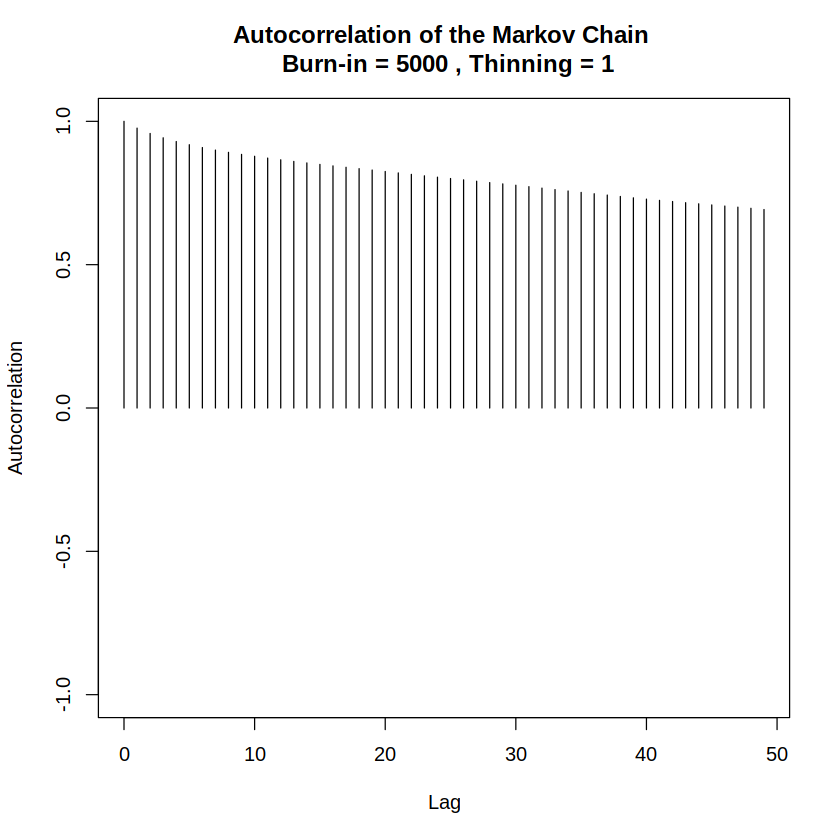

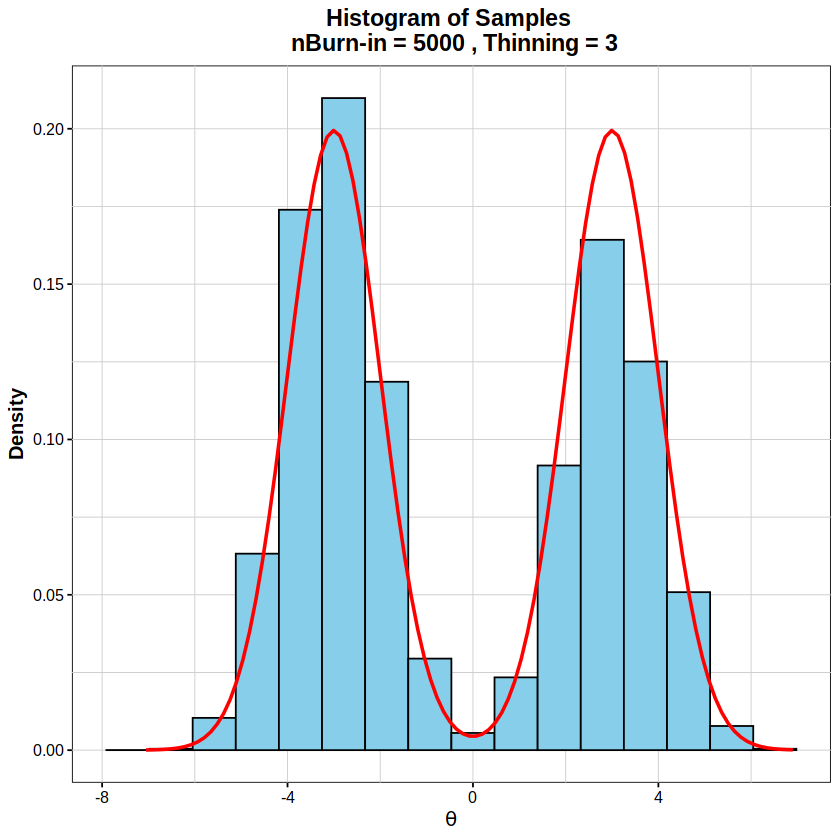

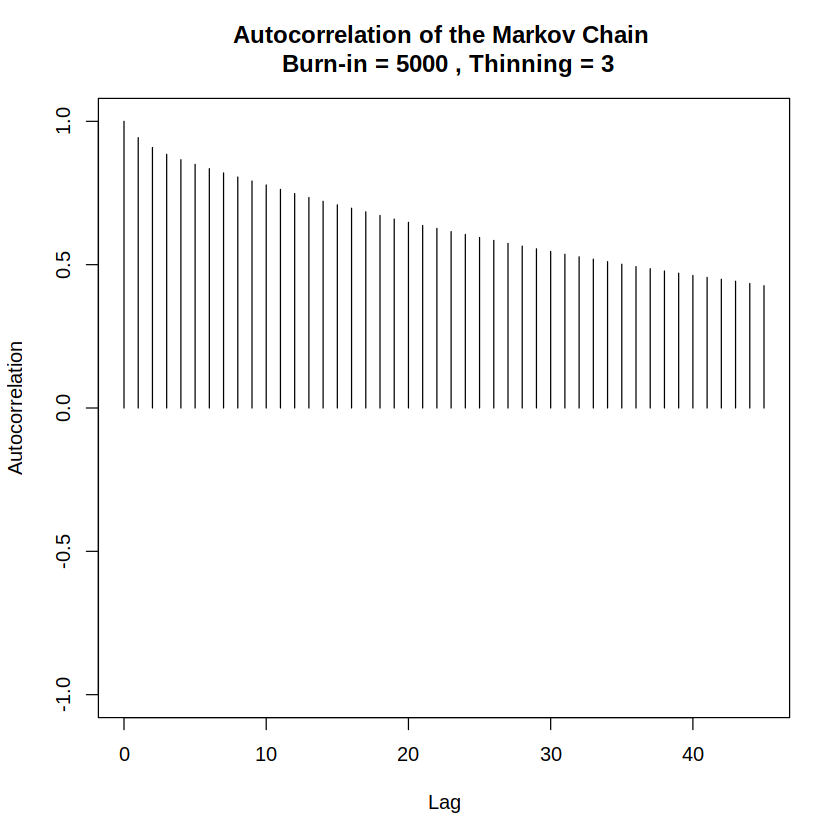

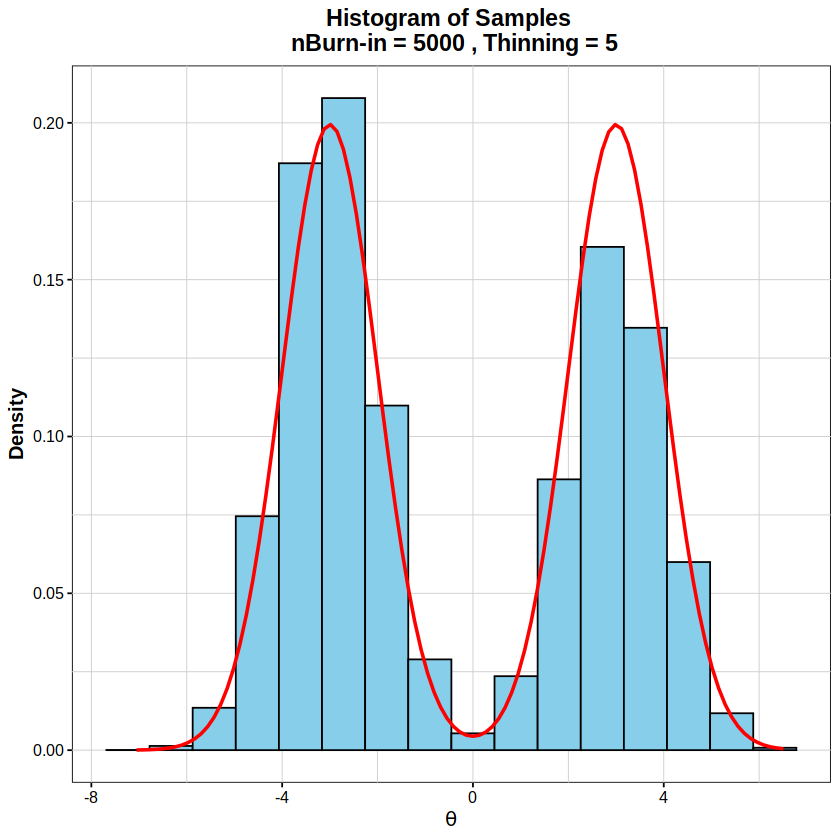

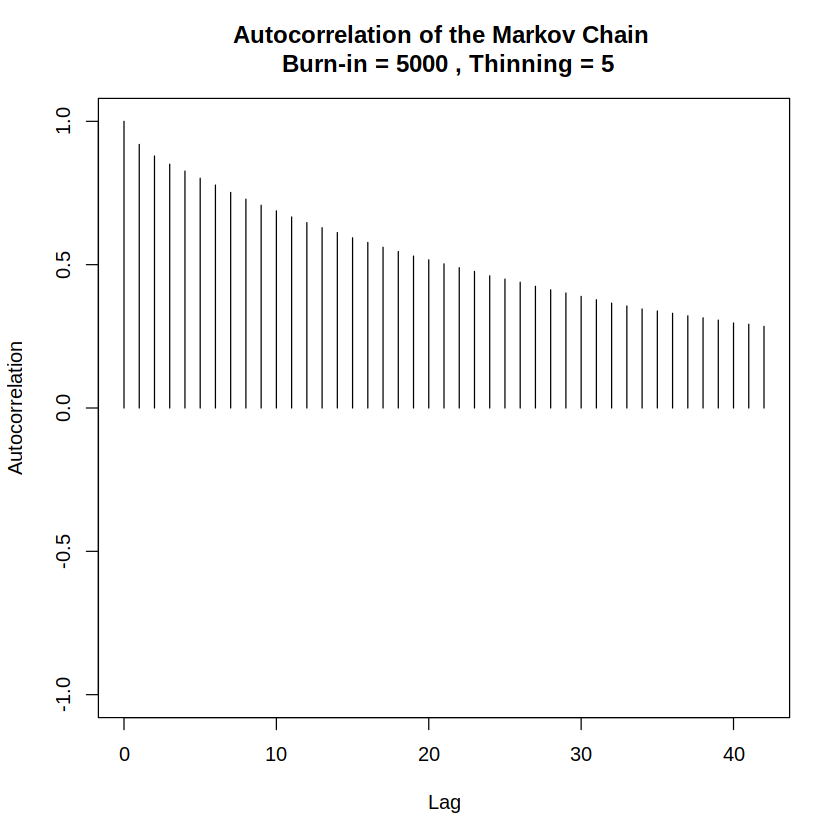

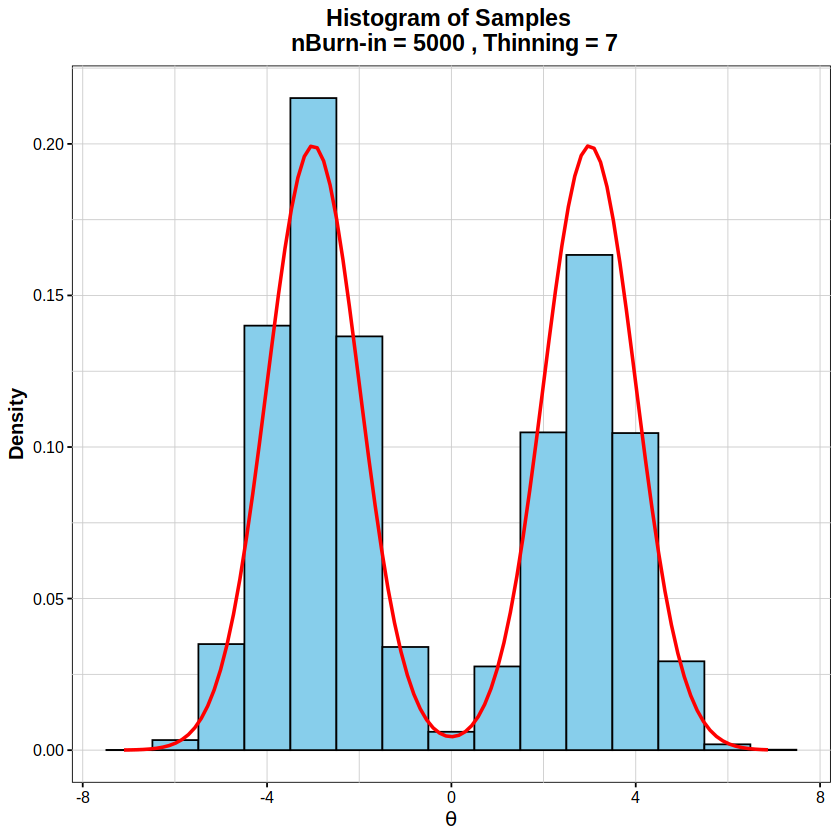

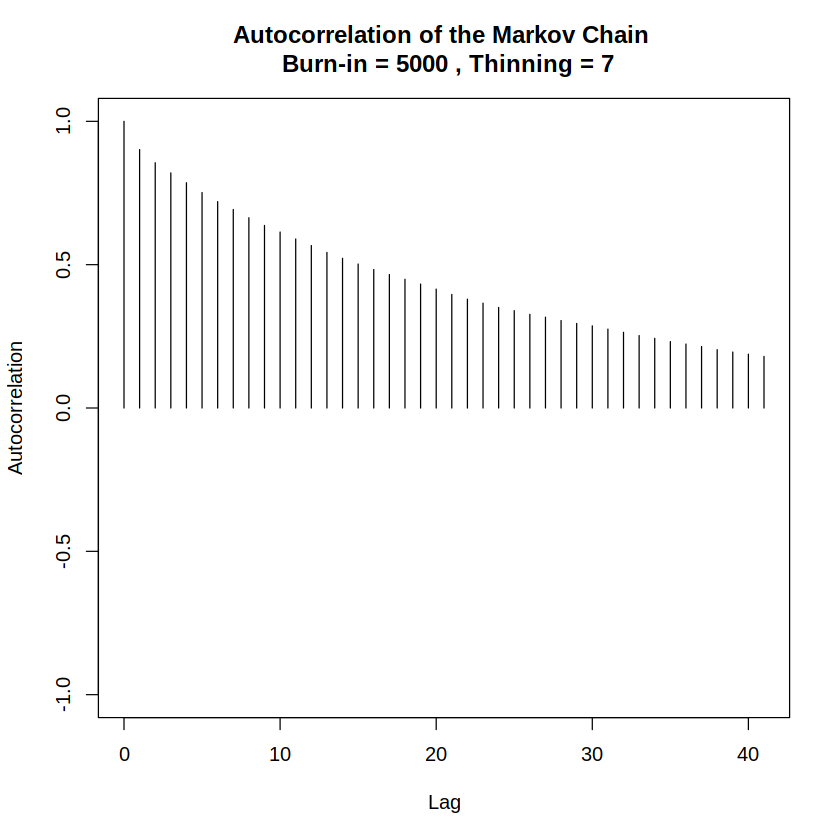

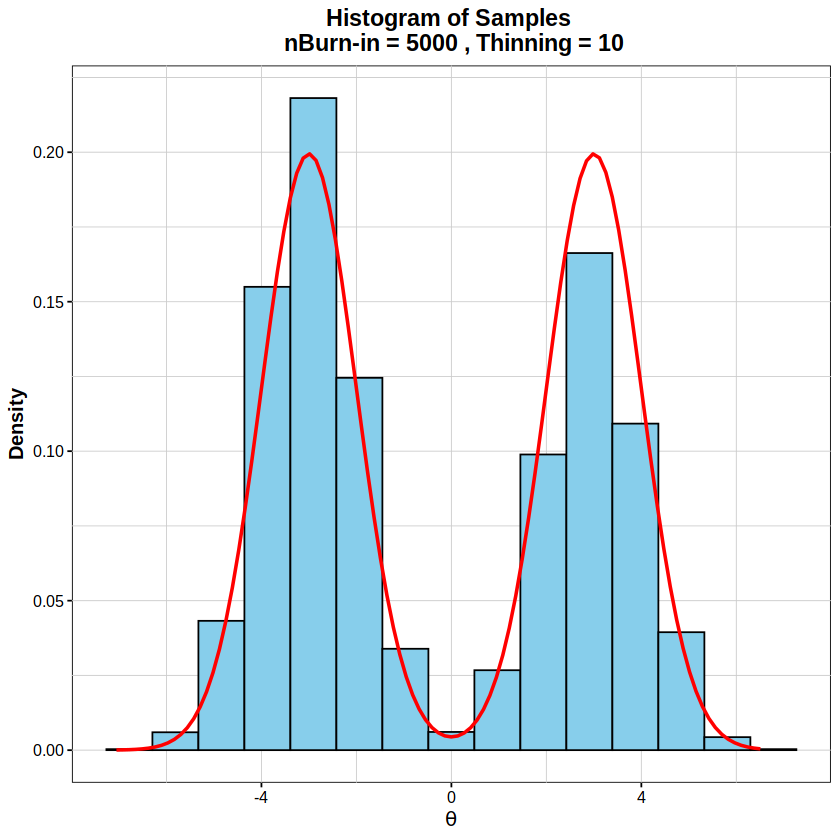

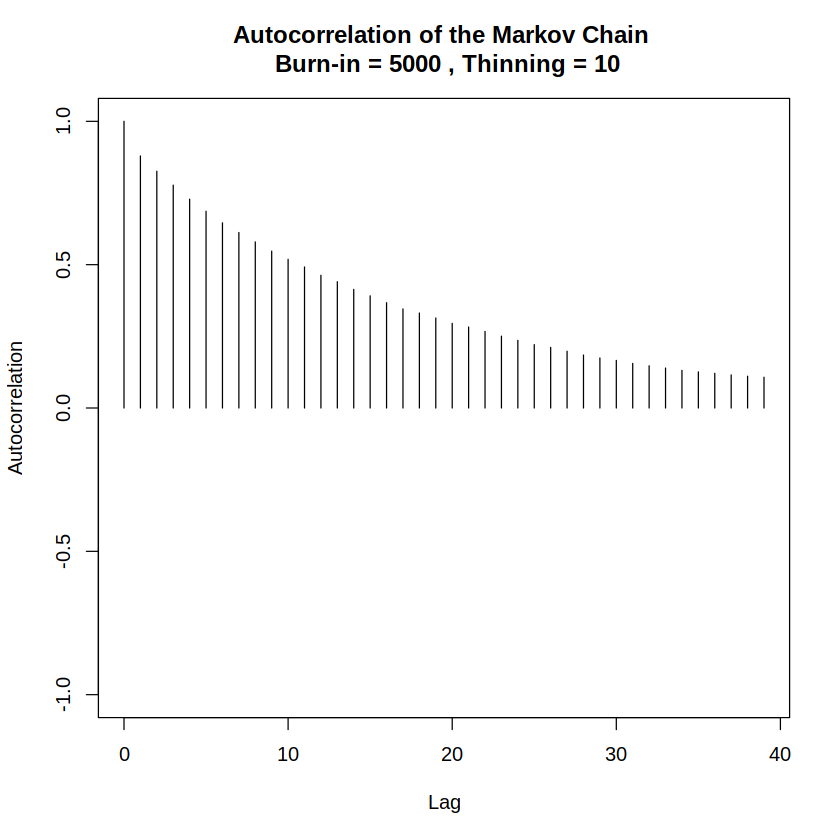

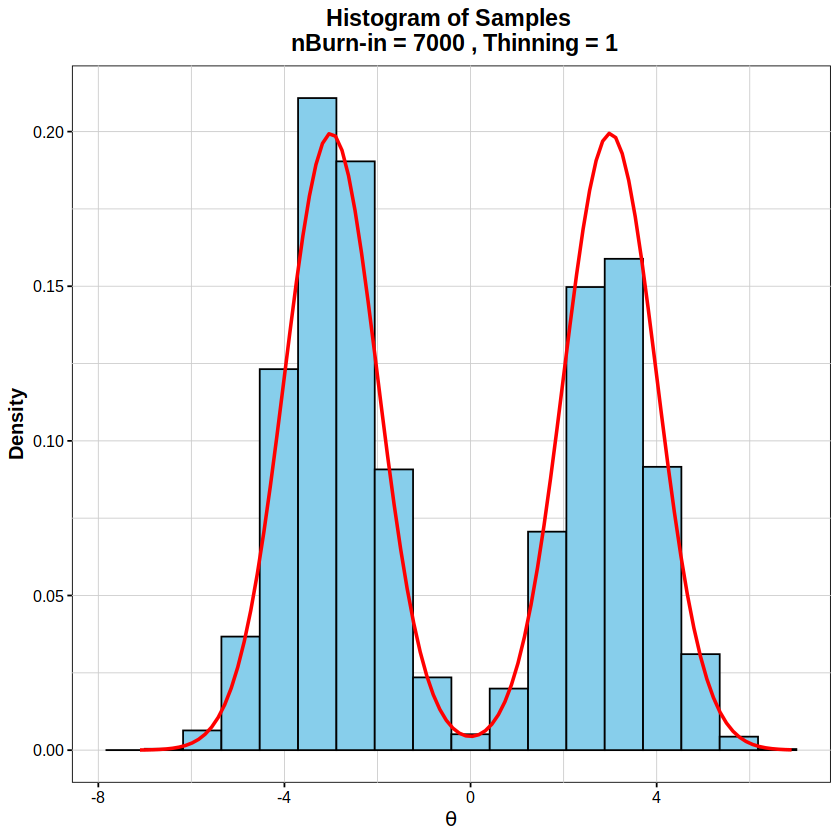

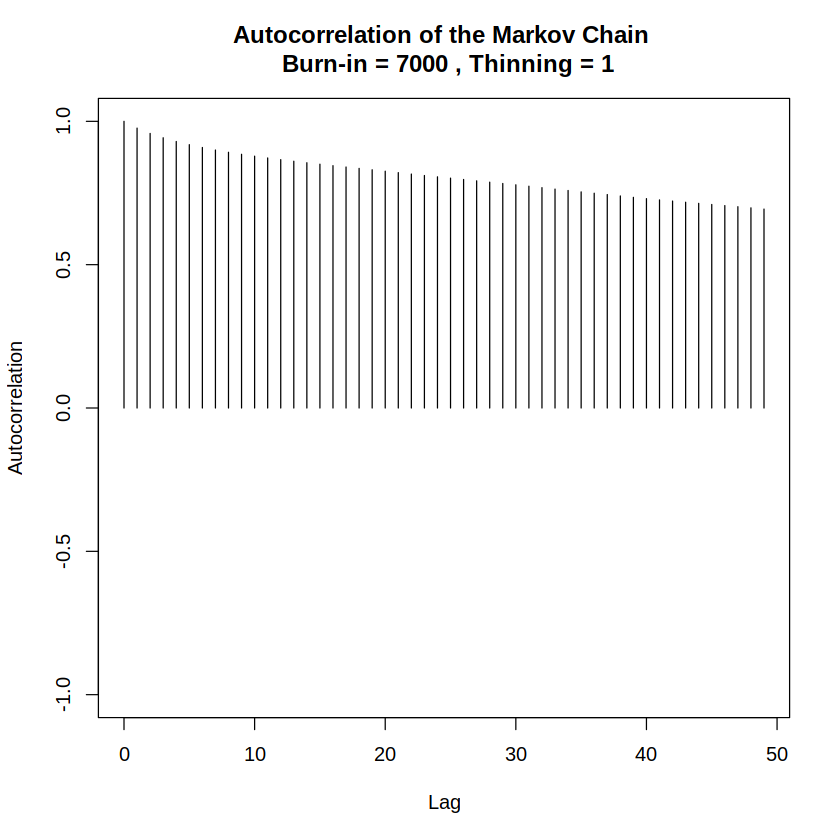

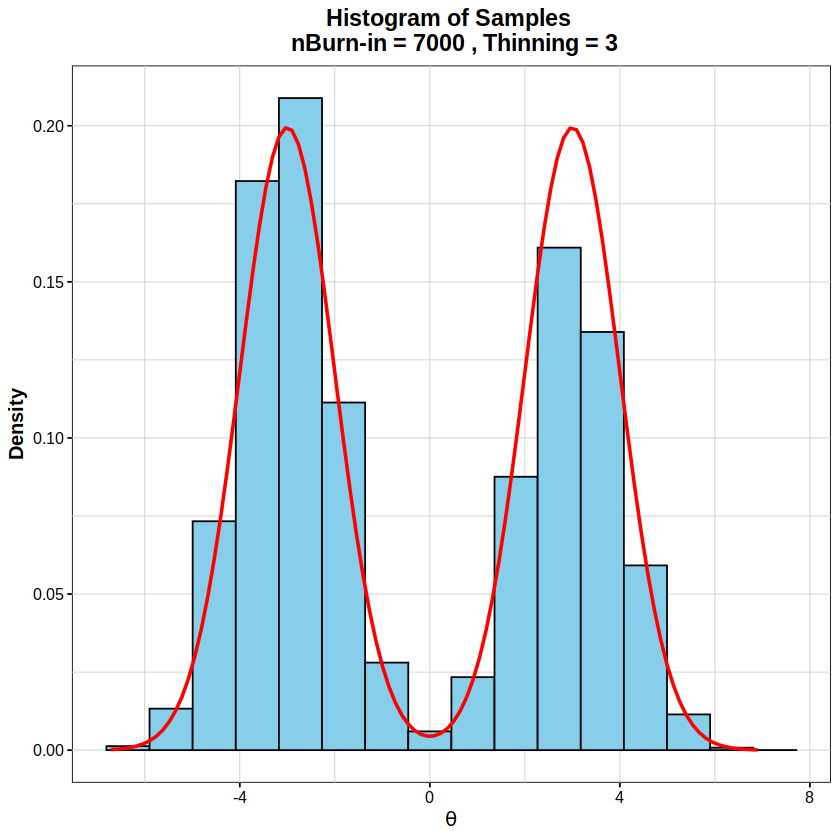

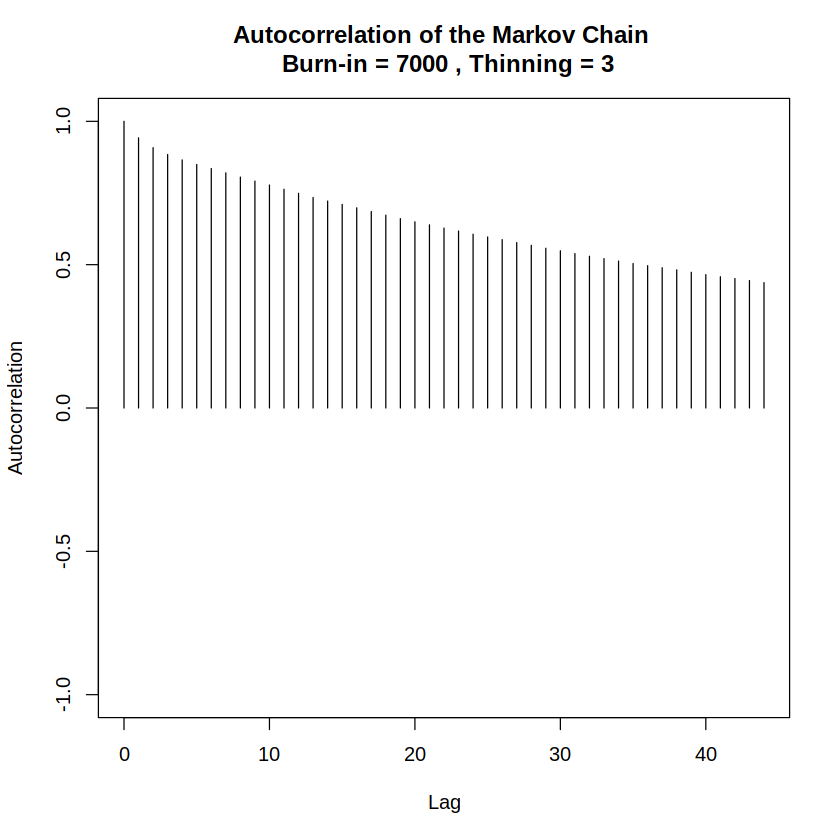

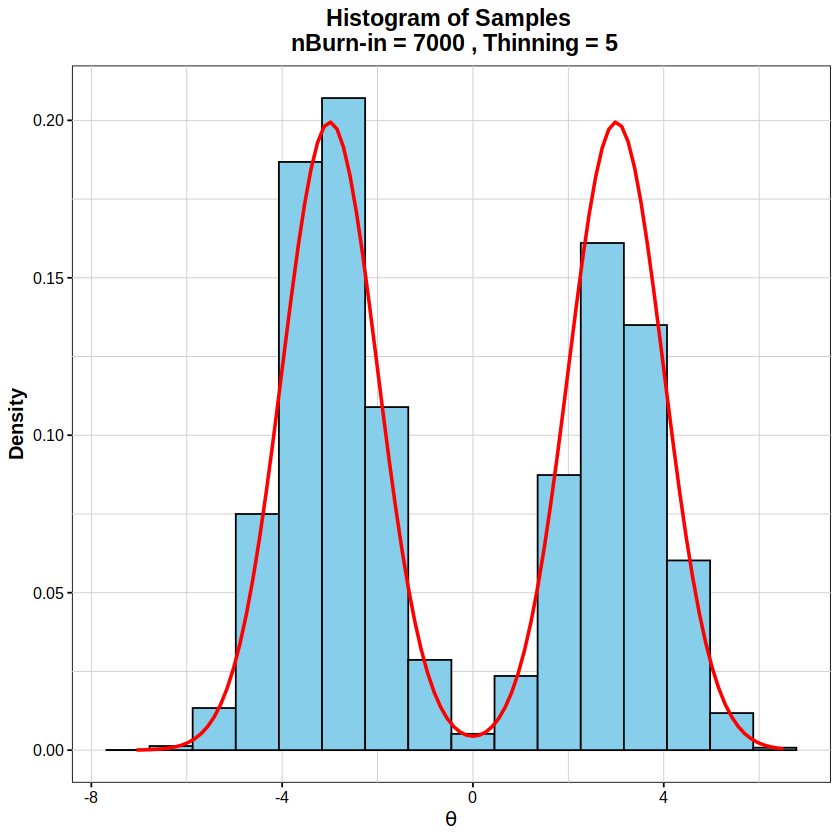

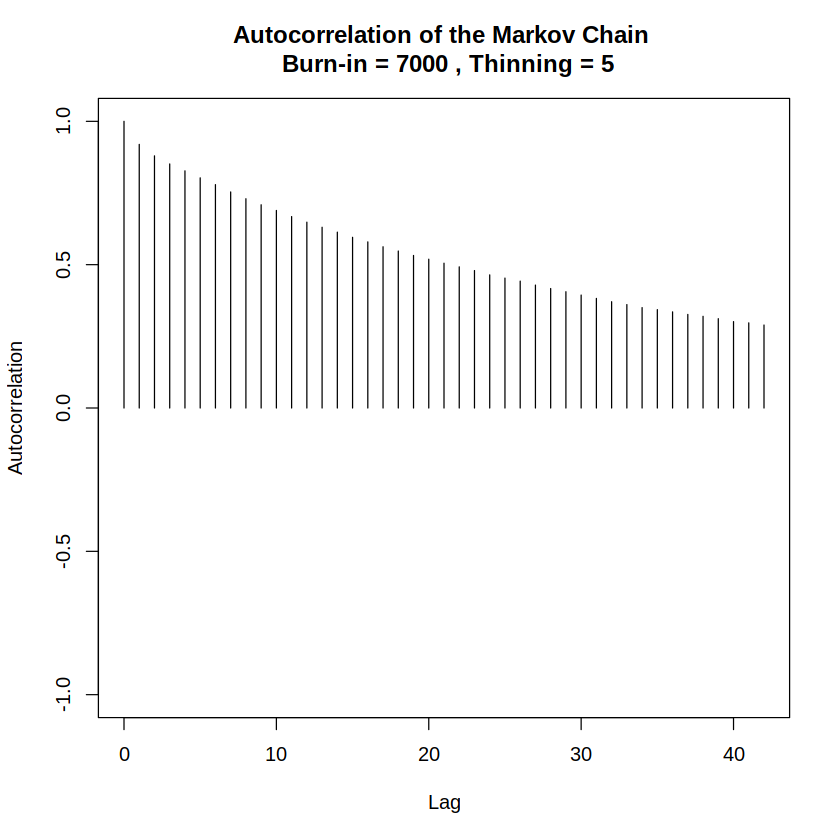

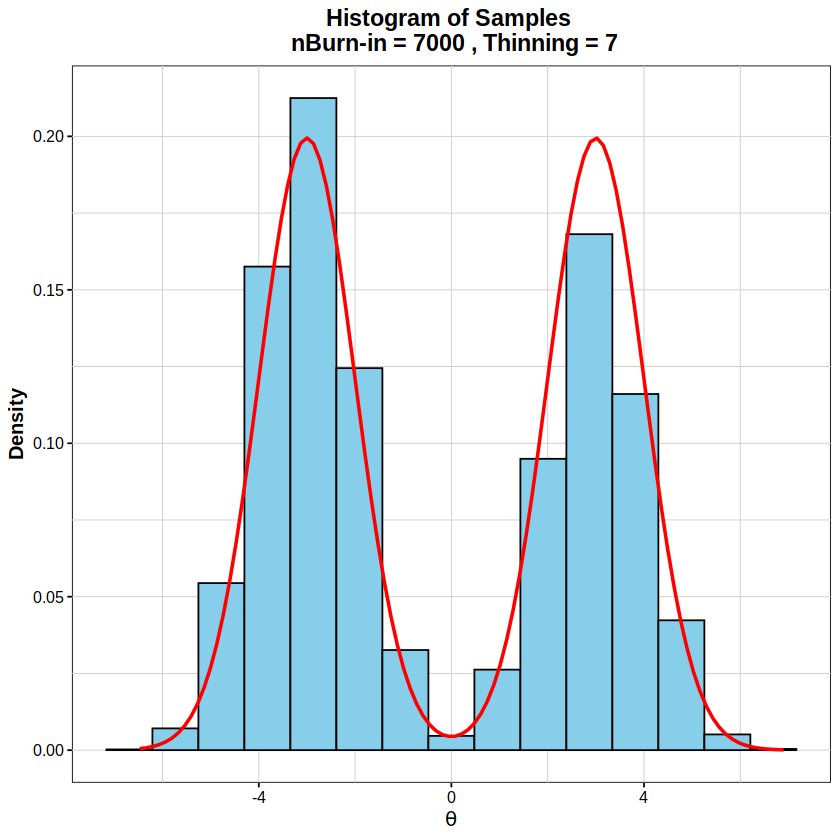

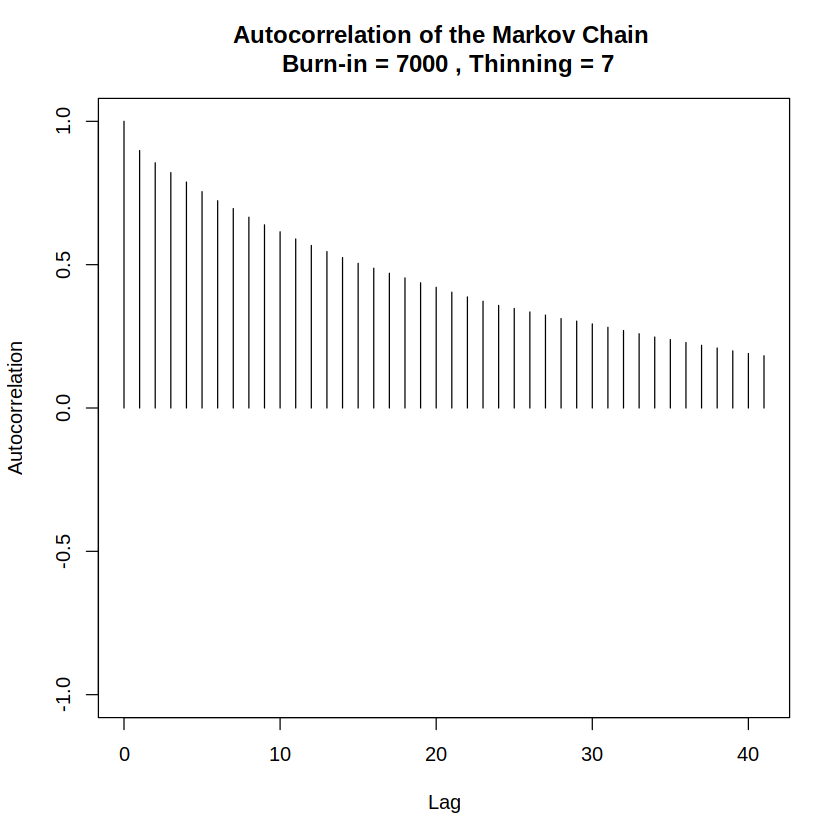

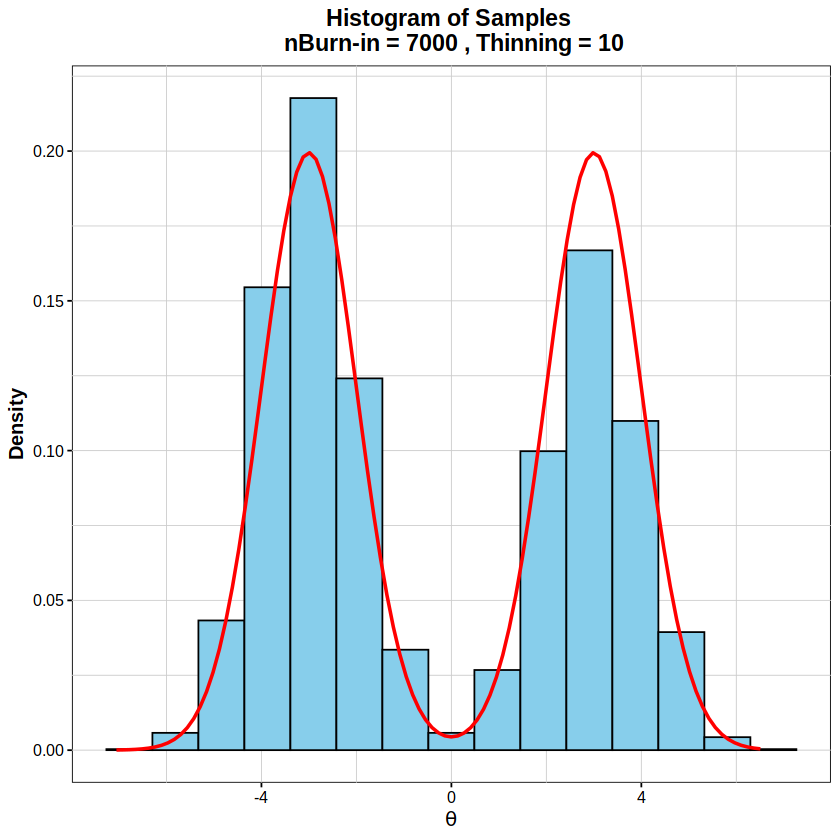

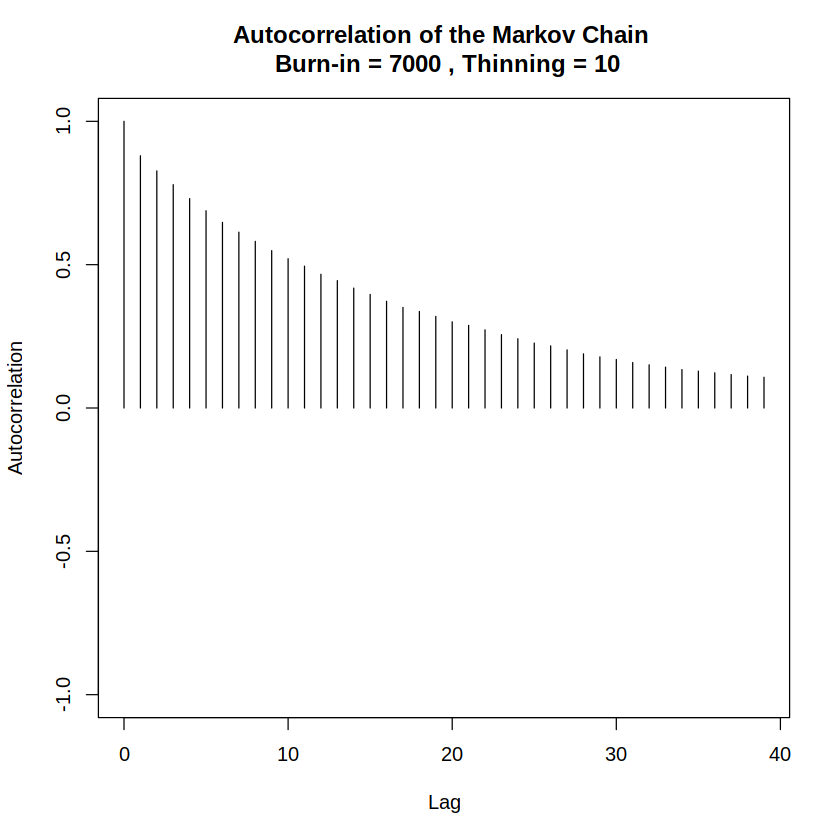

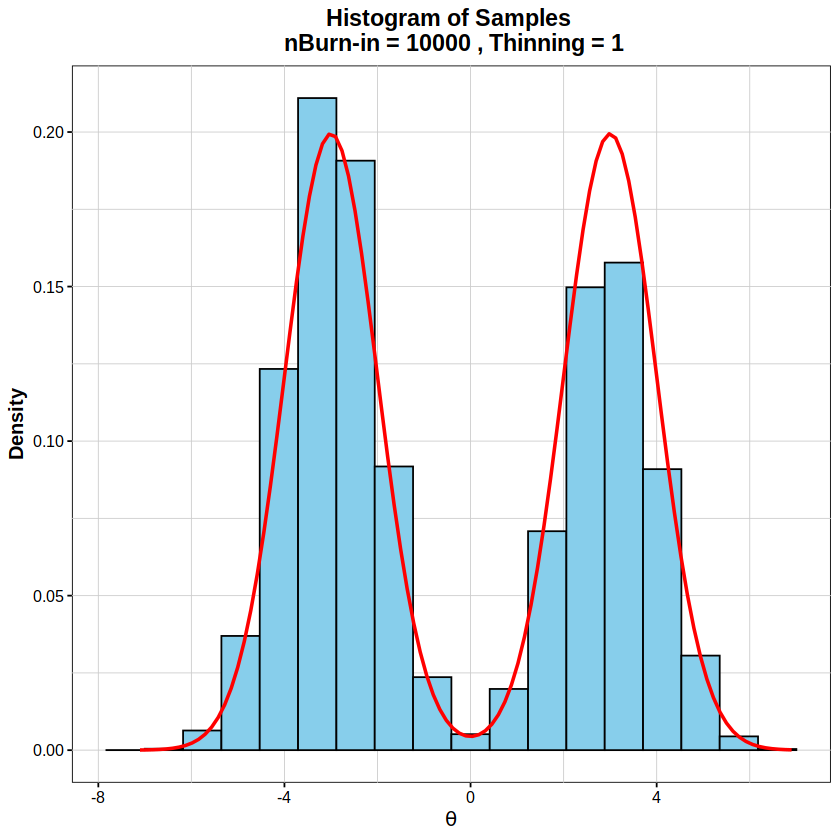

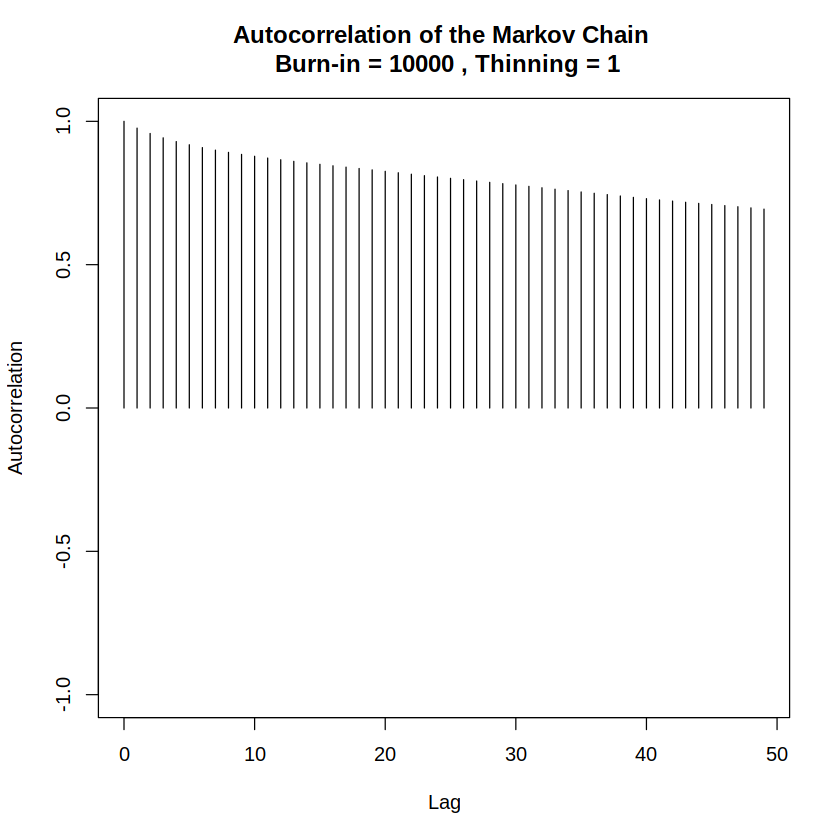

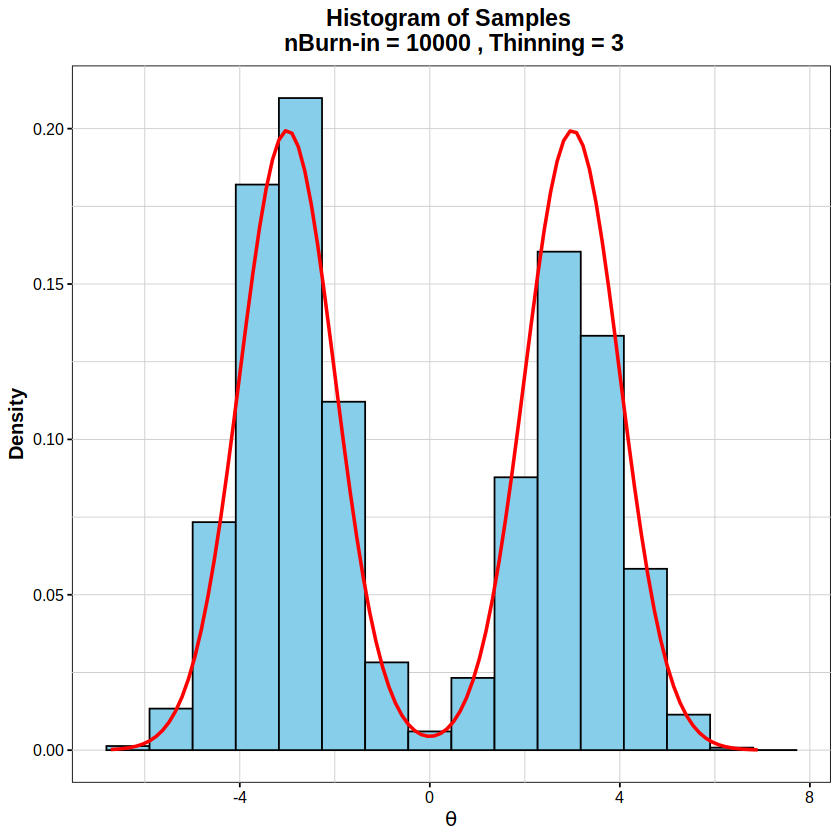

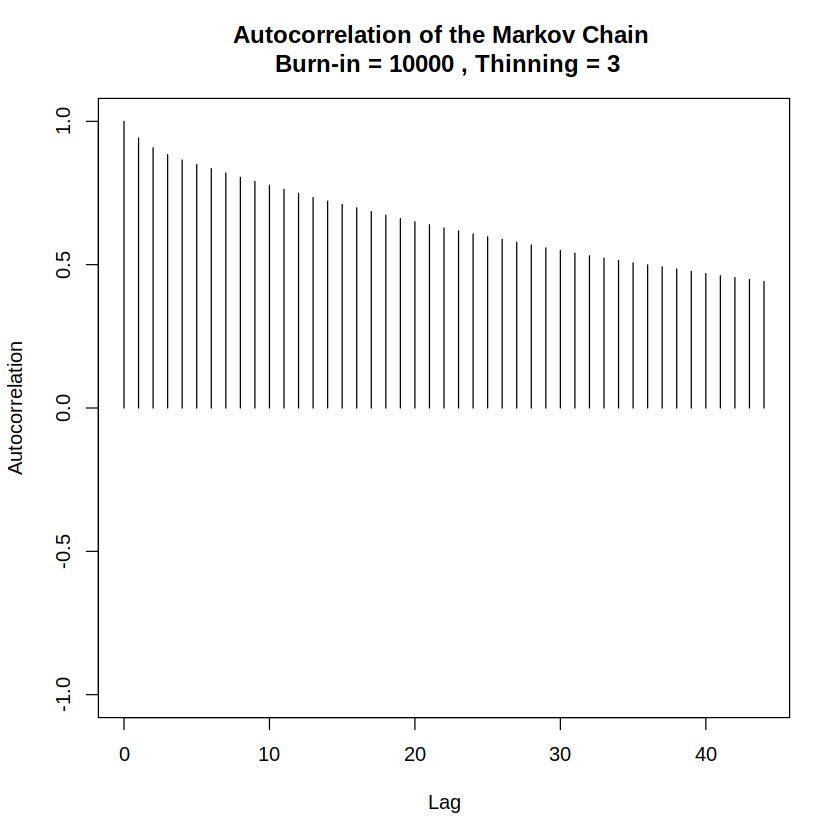

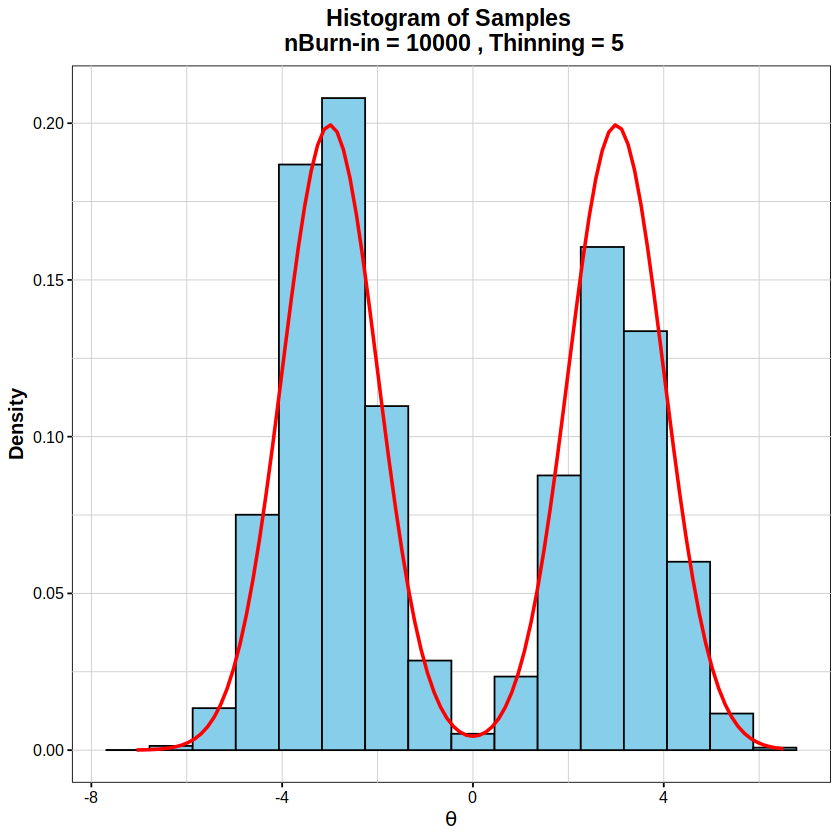

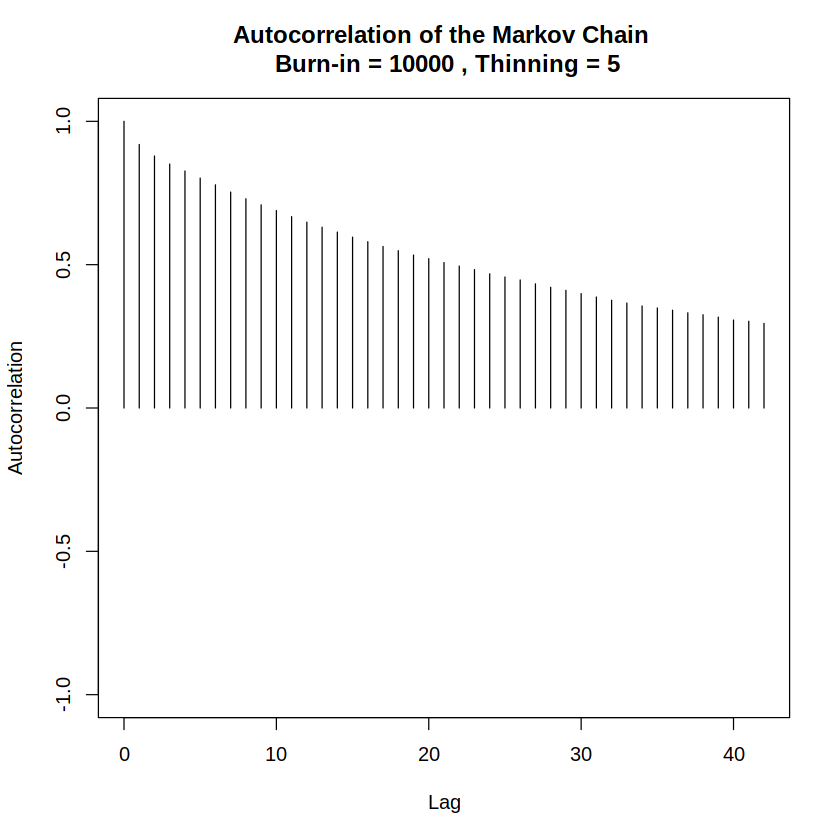

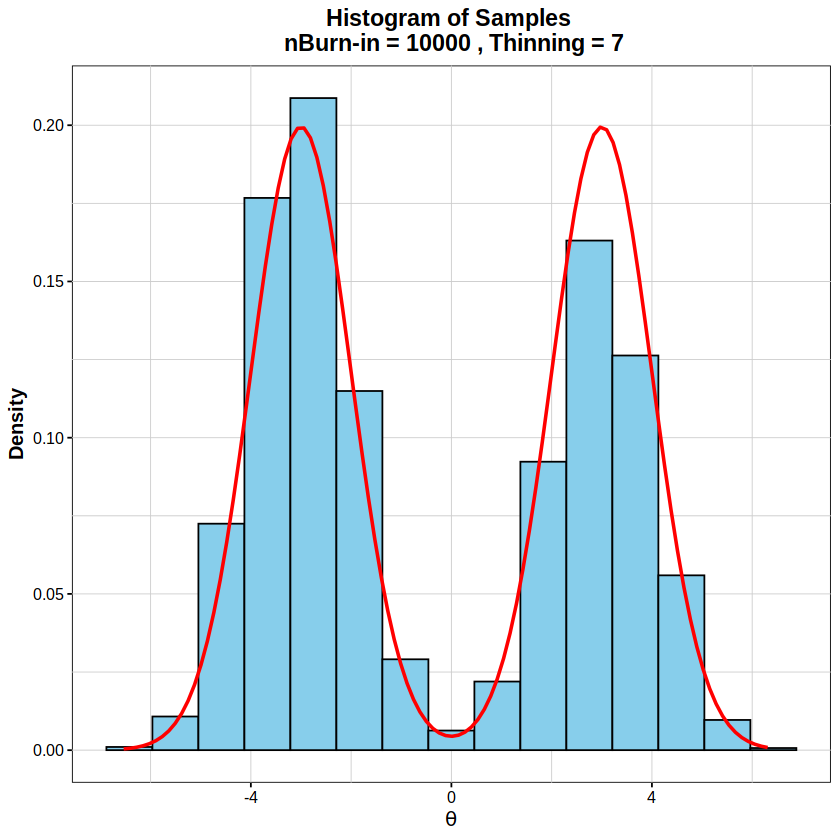

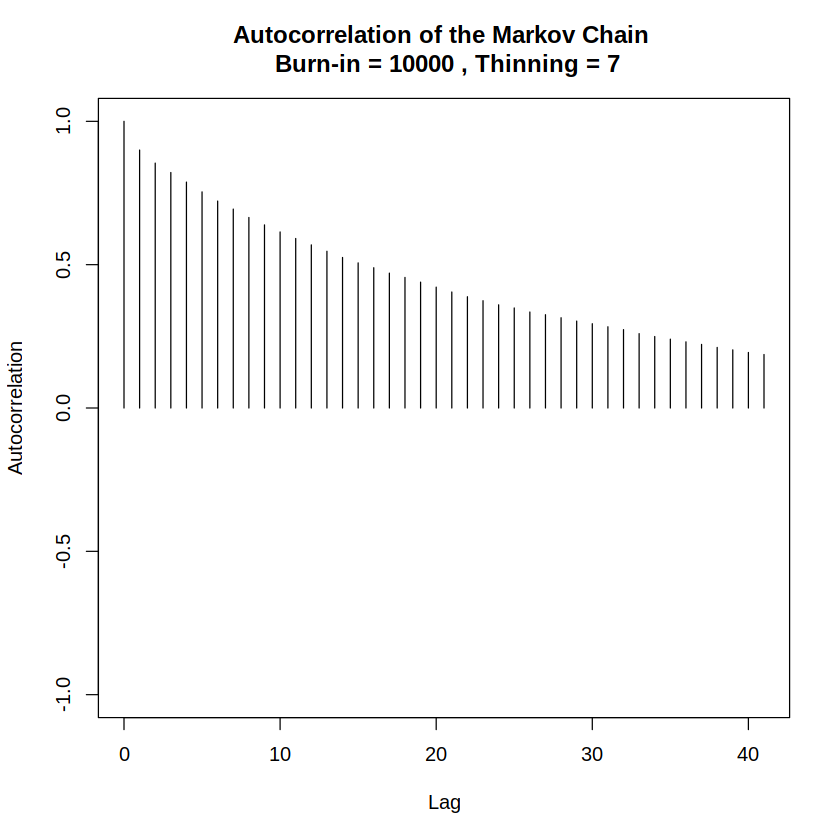

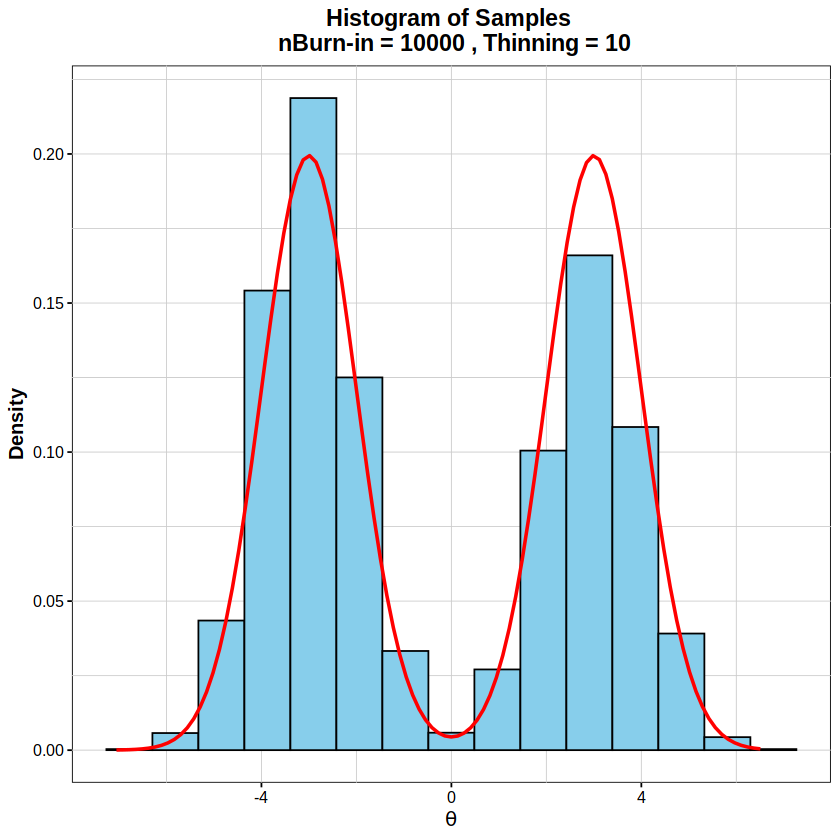



Table: Effective Sample Size (ESS) and Autocorrelation Time (ACT) for Different Burn-in and Thinning Parameters

|       | Burnin| Thinning|      ESS|       ACT|
|:------|------:|--------:|--------:|---------:|
|var1   |   1000|        1| 337.4095| 42.345188|
|var11  |   1000|        3| 318.5786| 17.421456|
|var12  |   1000|        5| 339.1013| 12.470608|
|var13  |   1000|        7| 330.9379|  9.952647|
|var14  |   1000|       10| 308.0663|  8.300241|
|var15  |   3000|        1| 321.5798| 42.312801|
|var16  |   3000|        3| 323.9318| 17.384969|
|var17  |   3000|        5| 321.3088| 12.469503|
|var18  |   3000|        7| 327.6332| 10.038120|
|var19  |   3000|       10| 298.3480|  8.319689|
|var110 |   5000|        1| 317.2036| 42.086557|
|var111 |   5000|        3| 317.4928| 17.551262|
|var112 |   5000|        5| 275.8629| 12.401756|
|var113 |   5000|        7| 304.4301| 10.135683|
|var114 |   5000|       10| 328.4567|  8.278135|
|var115 |   7000|        1| 306.6857| 42.185179|
|va

[1] "Low burning and thinning values prodocue a high ESS but a high ACT too. The best combinations of parameter is indeed the var 13."


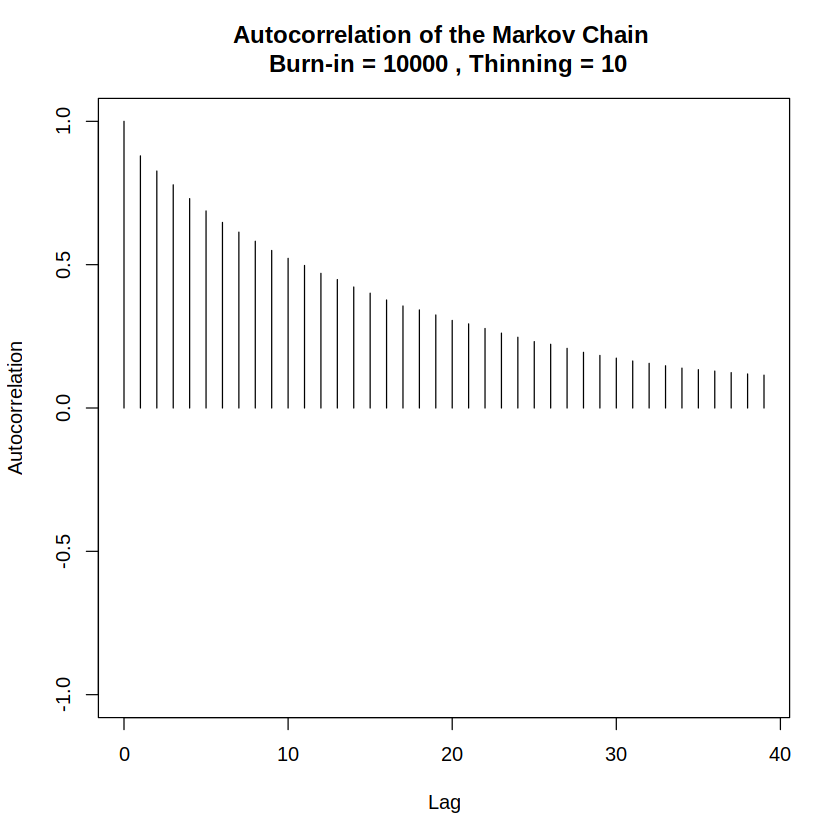

In [4]:
burnin_values = c(1000, 3000, 5000, 7000, 10000)
thin_values = c(1, 3, 5, 7, 10)

burnin_thinning = function(samples, burnin, thin) {
    if (burnin > 0) {
        samples = samples[-(1:burnin)] #removing the first burnin sample
    }
    if (thin > 1) {
        samples = samples[seq(1, length(samples), thin)] #keep every thin -th sample
    }
    return(samples)
}

results_df = data.frame(Burnin=integer(), Thinning=integer(), ESS=numeric(), ACT=numeric())

for (burnin in burnin_values) {
    for (thin in thin_values) {
        bt_samples = burnin_thinning(samples, burnin, thin)
        bt_samples_df = data.frame(samples=bt_samples)
        bt_samples_mcmc = as.mcmc(bt_samples)
        ess = effectiveSize(bt_samples_mcmc)
        act = 1 / (1 - acf(bt_samples_mcmc, plot=FALSE)$acf[2])
        results_df = rbind(results_df, data.frame(Burnin=burnin, Thinning=thin, ESS=ess, ACT=act))
        bins_sturges = ceiling(log2(length(bt_samples)) + 1)
        plot = ggplot(bt_samples_df, aes(x=samples)) +
            geom_histogram(aes(y = after_stat(density)), bins=bins_sturges, fill="skyblue", color="black") + 
            stat_function(fun=function(x) 0.5*dnorm(x, mean =-3, sd=1) + 0.5*dnorm(x, mean=3, sd=1), color = "red", linewidth = 1) + 
            labs(x=expression(theta), 
                 y="Density", 
                 title=paste("Histogram of Samples",'\n',"nBurn-in =", burnin, ", Thinning =", thin)) + 
            theme(text = element_text(size=12),
                  axis.title.x = element_text(face="bold", size=12),
                  axis.title.y = element_text(face="bold", size=12),
                  axis.text = element_text(color="black"),
                  axis.ticks = element_line(color="black"),
                  plot.title = element_text(hjust=0.5, face="bold", size=14),
                  panel.background = element_rect(fill = "white", color = "black"),
                  panel.grid.major = element_line(linewidth=0.25, linetype='solid', color="grey80"),
                  panel.grid.minor = element_line(linewidth=0.25, linetype='solid', color="grey80"))
        print(plot)
        autocorr.plot(bt_samples_mcmc, main=paste("Autocorrelation of the Markov Chain", '\n', "Burn-in =", burnin, ", Thinning =", thin))
    }
}

kable(results_df, caption = "Effective Sample Size (ESS) and Autocorrelation Time (ACT) for Different Burn-in and Thinning Parameters")
print("Low burning and thinning values prodocue a high ESS but a high ACT too. The best combinations of parameter is indeed the var 13.")

### Exercise 2

A set of measured data should follow, according to the physics model applied to them, a linear behavior. Data are the following:

$$
\begin{array}{c|cccccccc}
Y & -7.821 & -1.494 & -15.444 & -10.807 & -13.735 & -14.442 & -15.892 & -18.326 \\
\hline
X & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 \\
\end{array}
$$

a) Perform a simple linear regression model running a Markov Chain Monte Carlo with JAGS (just another gibbs sampler), assuming that data follow the model:

$Z[i] \sim a + b * X[i]$

And the likelihood of the measured data follow a Gaussian likelihood distribution:

$Y[i] \sim dnorm(Z[i], c)$

You can constrain the parameter a, b and c to the following intervals: $a \in [1,10], \; b \in [-1,3] \; \text{and} \; c \in [0.034,4]$



In [20]:
X = seq(5,12,1)
Y = c(-7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.326)
N= length(Y)
data_list = list(X=X, Y=Y, N=N) #for jags

#i need to describe the model as a string for jags. a, b, c are priors. a is intercept, b is slope and c is the inverse of the variance
model = "model {
    for (i in 1:N) {
        Y[i] ~ dnorm(mu[i], c)
        mu[i] = a + b * X[i]
    }
    a ~ dunif(1, 10)
    b ~ dunif(-1, 3)
    c ~ dunif(0.034, 4)
}"

model_connection = textConnection(model)
lin_reg = jags.model(model_connection, data=data_list, n.chains=5, n.adapt=10000) #n.chains number of chains, n.adapt number of adapt steps

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 3
   Total graph size: 42

Initializing model



b) Run JAGS experimenting with the burnin and number of iterations of the chain. Plot the evolution of the chains and the posterior distributions of a and b. Compute the 95% credibility interval for the parameters.

[[1]]
        lower    upper
var1 1.000089 2.425789
attr(,"Probability")
[1] 0.95

[[2]]
        lower    upper
var1 1.000224 2.355578
attr(,"Probability")
[1] 0.95

[[3]]
        lower    upper
var1 1.000248 2.406488
attr(,"Probability")
[1] 0.95

[[1]]
          lower      upper
var1 -0.9999715 -0.8526724
attr(,"Probability")
[1] 0.95

[[2]]
          lower      upper
var1 -0.9999976 -0.8331831
attr(,"Probability")
[1] 0.95

[[3]]
          lower      upper
var1 -0.9999951 -0.8377398
attr(,"Probability")
[1] 0.95

[[1]]
        lower    upper
var1 1.000048 2.355078
attr(,"Probability")
[1] 0.95

[[2]]
        lower    upper
var1 1.000025 2.440292
attr(,"Probability")
[1] 0.95

[[3]]
        lower    upper
var1 1.000129 2.420199
attr(,"Probability")
[1] 0.95

[[1]]
          lower      upper
var1 -0.9999855 -0.8444268
attr(,"Probability")
[1] 0.95

[[2]]
          lower      upper
var1 -0.9999892 -0.8356068
attr(,"Probability")
[1] 0.95

[[3]]
     lower      upper
var1    -1 -0.85225

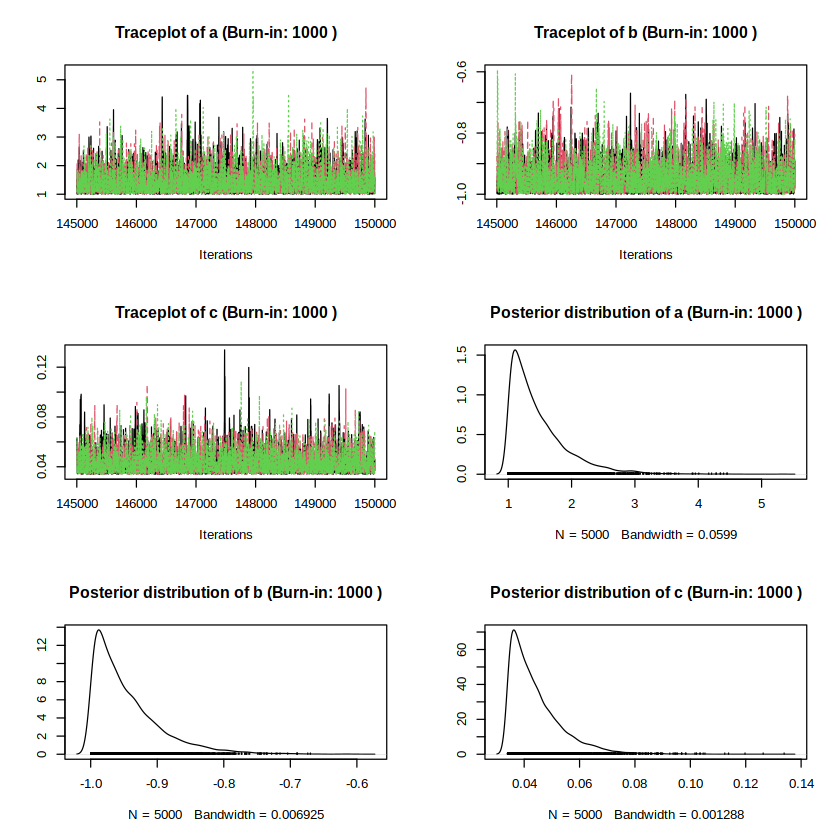

[[1]]
        lower    upper
var1 1.000121 2.422551
attr(,"Probability")
[1] 0.95

[[2]]
        lower    upper
var1 1.000026 2.442462
attr(,"Probability")
[1] 0.95

[[3]]
        lower    upper
var1 1.000012 2.440049
attr(,"Probability")
[1] 0.95

[[1]]
     lower      upper
var1    -1 -0.8453056
attr(,"Probability")
[1] 0.95

[[2]]
          lower      upper
var1 -0.9999982 -0.8435847
attr(,"Probability")
[1] 0.95

[[3]]
          lower      upper
var1 -0.9999985 -0.8395262
attr(,"Probability")
[1] 0.95



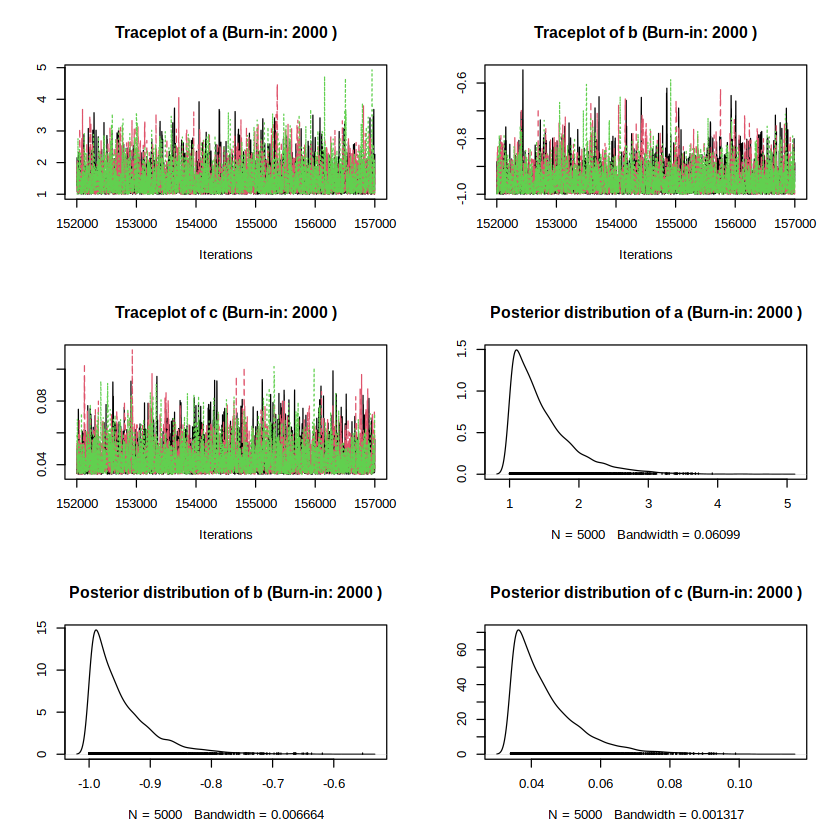

[[1]]
        lower    upper
var1 1.000005 2.505514
attr(,"Probability")
[1] 0.95

[[2]]
        lower    upper
var1 1.000181 2.304429
attr(,"Probability")
[1] 0.95

[[3]]
        lower    upper
var1 1.000014 2.378197
attr(,"Probability")
[1] 0.95

[[1]]
          lower      upper
var1 -0.9999838 -0.8384113
attr(,"Probability")
[1] 0.95

[[2]]
          lower      upper
var1 -0.9999999 -0.8390375
attr(,"Probability")
[1] 0.95

[[3]]
         lower      upper
var1 -0.999998 -0.8514037
attr(,"Probability")
[1] 0.95



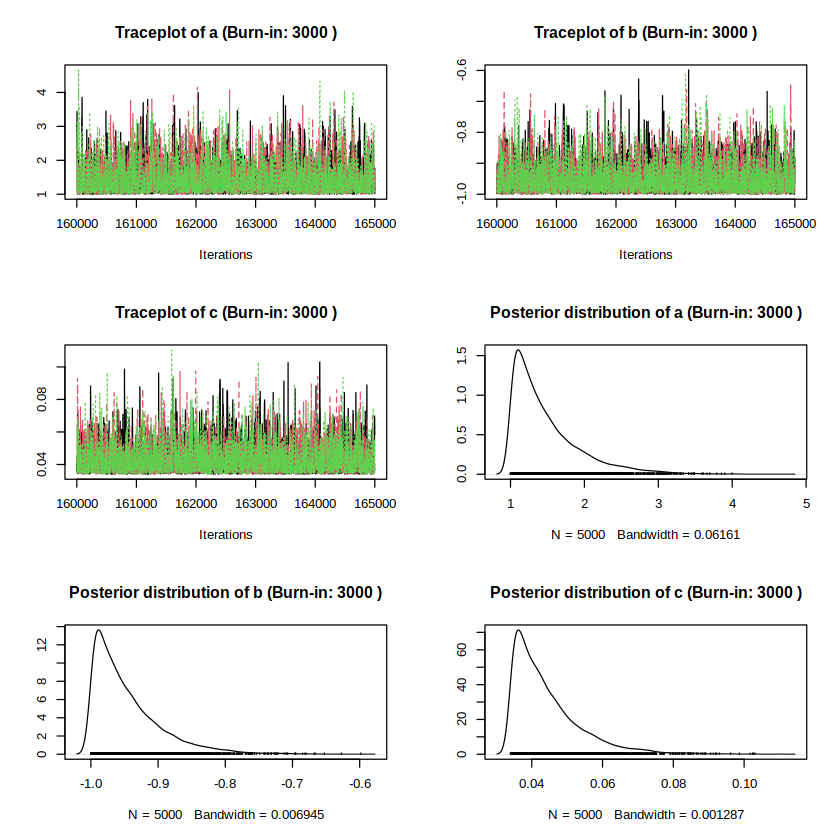

[[1]]
        lower    upper
var1 1.000361 2.433175
attr(,"Probability")
[1] 0.95

[[2]]
        lower    upper
var1 1.000021 2.453564
attr(,"Probability")
[1] 0.95

[[3]]
        lower    upper
var1 1.000554 2.409826
attr(,"Probability")
[1] 0.95

[[1]]
          lower      upper
var1 -0.9999819 -0.8452656
attr(,"Probability")
[1] 0.95

[[2]]
          lower      upper
var1 -0.9999994 -0.8367434
attr(,"Probability")
[1] 0.95

[[3]]
          lower      upper
var1 -0.9999894 -0.8417913
attr(,"Probability")
[1] 0.95



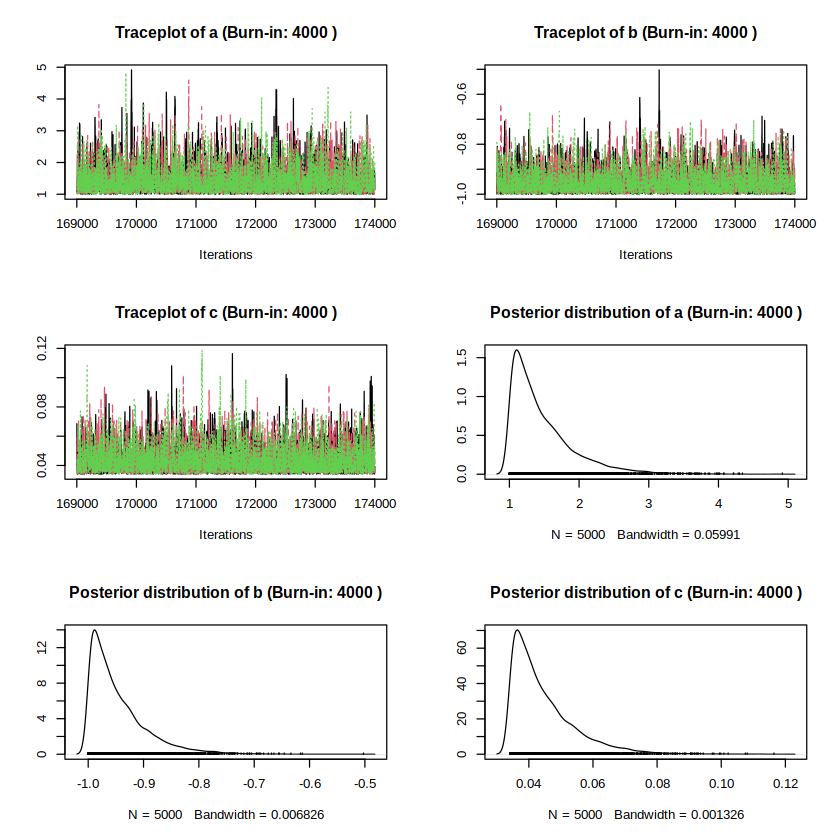

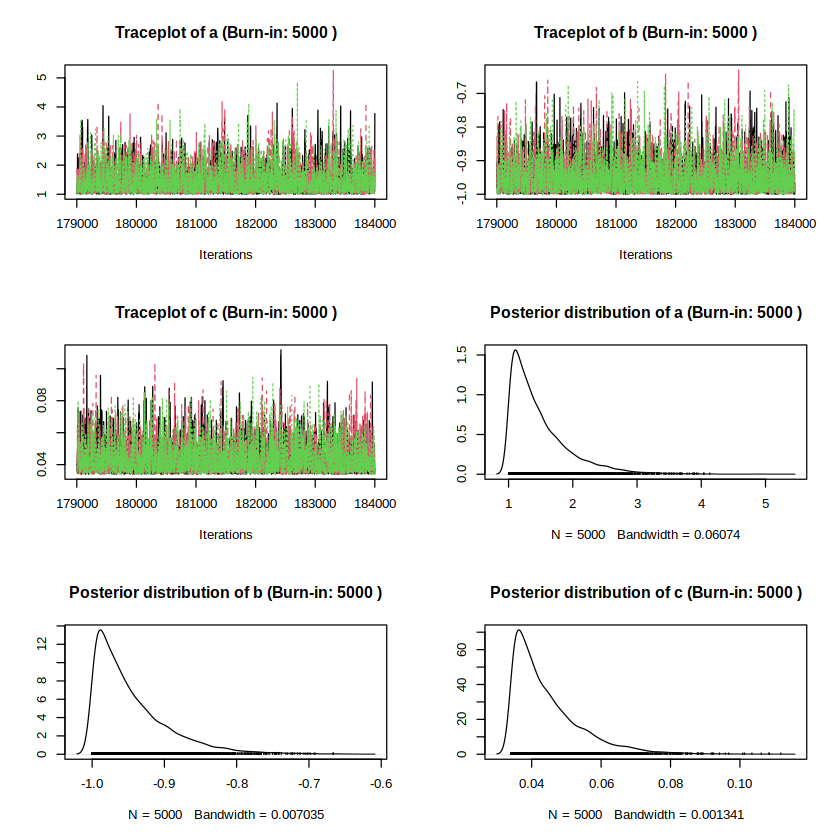

In [25]:
burnin = seq(1000, 5000, 1000)
n = 5000
parameters = c("a", "b", "c")

for (i in burnin) {
    update(jags_model, i)
    samples = coda.samples(jags_model, variable.names=parameters, n.iter=n)
    ci_a = HPDinterval(samples[, "a"])
    ci_b = HPDinterval(samples[, "b"])
    print(ci_a)
    print(ci_b)
    par(mfrow = c(3, 2))
    traceplot(samples[, "a"], main=paste("Traceplot of a (Burn-in:", i, ")"))
    traceplot(samples[, "b"], main=paste("Traceplot of b (Burn-in:", i, ")"))
    traceplot(samples[, "c"], main=paste("Traceplot of c (Burn-in:", i, ")"))
    densplot(samples[, "a"], main=paste("Posterior distribution of a (Burn-in:", i, ")"))
    densplot(samples[, "b"], main=paste("Posterior distribution of b (Burn-in:", i, ")"))
    densplot(samples[, "c"], main=paste("Posterior distribution of c (Burn-in:", i, ")"))
}

c) Using the obtained posterior distributions, compute the posterior distribution of σ = 1/ c

In [24]:
c_samples = as.matrix(samples[, "c"])
sigma_samples = 1 / sqrt(c_samples)
ci_sigma = quantile(sigma_samples, c(0.025, 0.975))
print(ci_sigma)

    2.5%    97.5% 
3.795279 5.399978 


### Exercise 3

Suppose we observe the following values:

x = c(2.06, 5.56, 7.93, 6.56, 2.05)

and we assume that the data come from a gaussian distribution with unknown mean m and variance $s^2$

a) Build a simple JAGS model and run a MCMC to obtain the posterior distribution of the mean and variance. Assume uniform prior distributions for the parameters,

m $\sim$ dunif(-10, 10) and s $\sim$ dunif(0,50)

Compute also the posterior for m/s

### Exercise 4

The data set that Edwin Hubble ised to show that galaxies are moving  either away or towards us are given in the following table:

$$
\begin{array}{c|ccccc}
D & 0.0032 & 0.0034 & 0.214 & 0.263 & 0.275 \\
V & 170 & 290 & -130 & -70 & -185 \\
\hline
D & 0.275 & 0.45 & 0.5 & 0.5 & 0.63 \\
V & -220 & 200 & -290 & 270 & 200 \\
\hline
D & 0.8 & 0.9 & 0.9 & 0.9 & 0.9 \\
V & 920 & 450 & 500 & 500 & 960 \\
\hline
D & 2 & 2 & 2 & 2 \\
V & 500 & 850 & 800 & 1090 \\
\end{array}
$$

a) Using this data set define a JAGS model to fit data with the following:

$V[i] \sim dnorm(b * D[i], c)$

Where V represent the velocity in units of km/s, D is the observed distance (in units of parsec) and b and c two parameters of the model.
Assume whatever prior distribution you think is appropriate.

b) Plot the evolution of the chains, the posterior distribution of the parameters and the 95% credibility interval.